<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">Time-Series Forecasting of Carbon Monoxide and Nitrogen Dioxide Levels</h2>

Build predictive models to forecast daily or hourly concentrations of **CO(GT)** and **NO₂(GT)** based on historical data.


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# ML libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# DL libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

# Time Series Analysis libraries
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller (ADF) Test
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Ignore warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [51]:
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'
df = pd.read_csv(url)
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  2004-03-10  18:00:00     2.6         1360       150      11.9   
1  2004-03-10  19:00:00     2.0         1292       112       9.4   
2  2004-03-10  20:00:00     2.2         1402        88       9.0   
3  2004-03-10  21:00:00     2.2         1376        80       9.2   
4  2004-03-10  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

In [52]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


In [54]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9357.000000  9357.000000  9357.000000  9357.000000    9357.000000   
mean    -34.207524  1048.990061  -159.090093     1.865683     894.595276   
std      77.657170   329.832710   139.789093    41.380206     342.333252   
min    -200.000000  -200.000000  -200.000000  -200.000000    -200.000000   
25%       0.600000   921.000000  -200.000000     4.000000     711.000000   
50%       1.500000  1053.000000  -200.000000     7.900000     895.000000   
75%       2.600000  1221.000000  -200.000000    13.600000    1105.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9357.000000   9357.000000  9357.000000   9357.000000  9357.000000   
mean    168.616971    794.990168    58.148873   1391.479641   975.072032   
std     257.433866    321.993552   126.940455    467.210125   456.938184   
min    -200.000000   -200.000000  -200.000000   -200.000000  -200.000000   
25%      50.000000    637.000000    53.000000   1185.000000   700.000000   
50%     141.000000    794.000000    96.000000   1446.000000   942.000000   
75%     284.000000    960.000000   133.000000   1662.000000  1255.000000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH  
count  9357.000000  9357.000000  9357.000000  
mean      9.778305    39.485380    -6.837604  
std      43.203623    51.216145    38.976670  
min    -200.000000  -200.000000  -200.000000  
25%      10.900000    34.100000     0.692300  
50%      17.200000    48.600000     0.976800  
75%      24.100000    61.900000     1.296200  
max      44.600000    88.700000     2.231000

In [55]:
print(df.isnull().sum())

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


In [56]:
df.shape

(9357, 15)

In [57]:
df.nunique()

Date              391
Time               24
CO(GT)             97
PT08.S1(CO)      1042
NMHC(GT)          430
C6H6(GT)          408
PT08.S2(NMHC)    1246
NOx(GT)           926
PT08.S3(NOx)     1222
NO2(GT)           284
PT08.S4(NO2)     1604
PT08.S5(O3)      1744
T                 437
RH                754
AH               6684
dtype: int64

In [58]:
df.duplicated().sum()

0

Count of negative values in each column:
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 379
RH                366
AH                366
dtype: int64


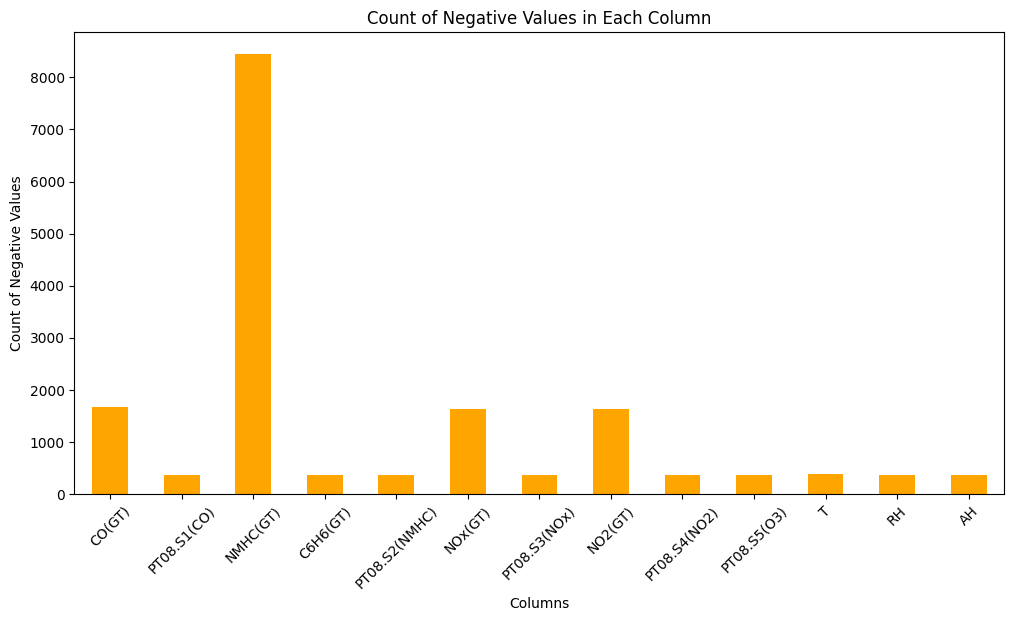

In [59]:
# Step 1: Ensure numeric columns
numeric_columns = df.select_dtypes(include=['number'])  # Select only numeric columns

# Step 2: Check for negative values in each column
negative_counts = (numeric_columns < 0).sum()

# Step 3: Filter only columns with negative values
negative_counts = negative_counts[negative_counts > 0]

# Step 4: Display counts of negative values
print("Count of negative values in each column:")
print(negative_counts)

# Step 5: Visualization
import matplotlib.pyplot as plt

if not negative_counts.empty:
    plt.figure(figsize=(12, 6))
    negative_counts.plot(kind='bar', color='orange')
    plt.title('Count of Negative Values in Each Column')
    plt.xlabel('Columns')
    plt.ylabel('Count of Negative Values')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No negative values found in numeric columns.")

In [60]:
#Converts the Time Date value to a string, last 4 characters of the string, representing the year.
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [61]:
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0 2004-03-10  18:00:00     2.6         1360       150      11.9   
1 2004-03-10  19:00:00     2.0         1292       112       9.4   
2 2004-03-10  20:00:00     2.2         1402        88       9.0   
3 2004-03-10  21:00:00     2.2         1376        80       9.2   
4 2004-03-10  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  Year  Month  Day  
0  13.6  48.9  0.7578  2004      3   10  
1  13.3  47.7  0.7255  2004      3   10  
2  11.9  54.0  0.7502  2004      3   10  
3  11.0  60.0  0.7867  2004      3   10  
4  11.2  59.6  0.7888  2004      3   10

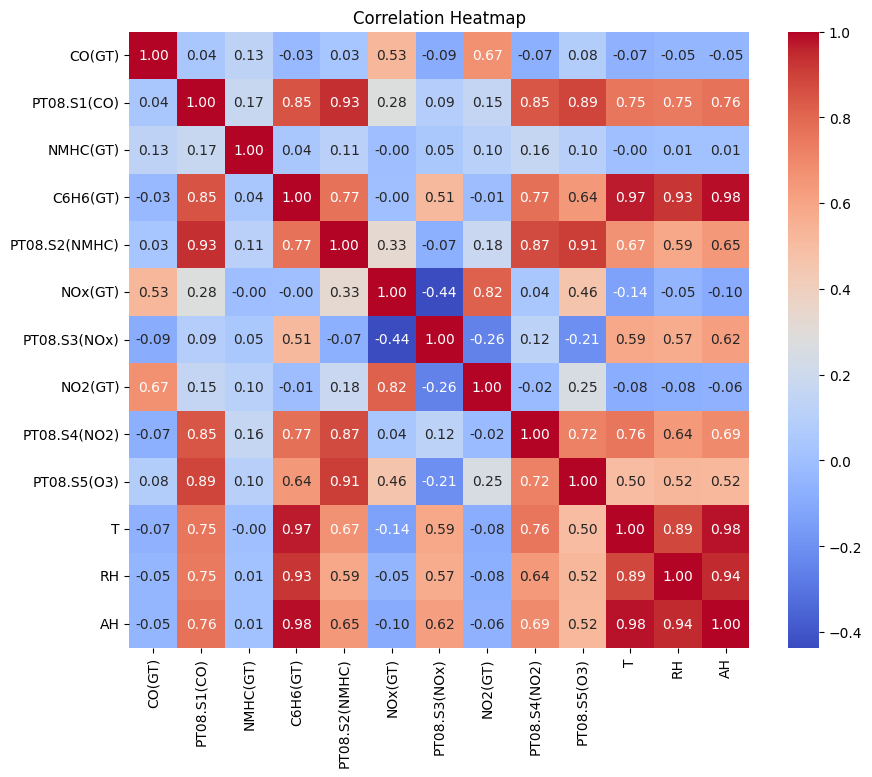

In [62]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">Project Workflow</h2>

---
### **Deliverables**:
1. **Forecasting Models**:
   - Trained models for `CO(GT)` and `NO₂(GT)`.
2. **Forecast Visualization**:
   - Plots showing historical trends and future predictions.
3. **Evaluation Report**:
   - Metrics and comparison of different forecasting models.
4. **Insights and Recommendations**:
   - Suggestions for mitigating high levels of these gases based on predictions.


### **1. Data Preprocessing**
---
- **Date-Time Parsing**:
  - Combine the `Date` and `Time` columns into a single `datetime` column.
  - Set the `datetime` column as the index of the dataset.
- **Resampling**:
  - Aggregate the data into meaningful time intervals (e.g., hourly or daily averages).
- **Handle Missing Values**:
  - Use interpolation, mean, or advanced imputation techniques to fill missing data for `CO(GT)` and `NO₂(GT)`.
- **Outlier Detection**:
  - Remove or cap extreme values in `CO(GT)` and `NO₂(GT)` using statistical thresholds.

In [63]:
# Date-Time Parsing
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.drop(columns=['Date', 'Time'], inplace=True)
df.set_index('datetime', inplace=True)

In [64]:
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
datetime                                                                      
2004-03-10 18:00:00     2.6         1360       150      11.9           1046   
2004-03-10 19:00:00     2.0         1292       112       9.4            955   
2004-03-10 20:00:00     2.2         1402        88       9.0            939   
2004-03-10 21:00:00     2.2         1376        80       9.2            948   
2004-03-10 22:00:00     1.6         1272        51       6.5            836   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
datetime                                                            
2004-03-10 18:00:00      166          1056      113          1692   
2004-03-10 19:00:00      103          1174       92          1559   
2004-03-10 20:00:00      131          1140      114          1555   
2004-03-10 21:00:00      172          1092      122          1584   
2004-03-10 22:00:00      131          1205      116          1490   

                     PT08.S5(O3)     T    RH      AH  Year  Month  Day  
datetime                                                                
2004-03-10 18:00:00         1268  13.6  48.9  0.7578  2004      3   10  
2004-03-10 19:00:00          972  13.3  47.7  0.7255  2004      3   10  
2004-03-10 20:00:00         1074  11.9  54.0  0.7502  2004      3   10  
2004-03-10 21:00:00         1203  11.0  60.0  0.7867  2004      3   10  
2004-03-10 22:00:00         1110  11.2  59.6  0.7888  2004      3   10

In [65]:
# Resample the data daily basis a. 
daily_data = df.resample('D').mean()
print(daily_data.head())

               CO(GT)  PT08.S1(CO)    NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
datetime                                                                   
2004-03-10   1.966667  1316.500000   86.500000   8.450000     912.333333   
2004-03-11  -6.187500  1244.166667  104.500000   7.979167     851.958333   
2004-03-12 -14.095833  1281.666667  141.500000  12.129167    1008.291667   
2004-03-13  -5.750000  1330.666667  139.250000  10.916667     992.833333   
2004-03-14  -5.966667  1361.125000  116.958333   9.637500     943.916667   

               NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
datetime                                                                      
2004-03-10  132.000000   1167.333333  108.833333   1545.500000  1096.000000   
2004-03-11  130.041667   1277.250000   87.375000   1522.833333   885.250000   
2004-03-12  142.583333   1101.875000   89.916667   1627.291667  1084.375000   
2004-03-13  168.416667    993.208333  105.583333   1595.791667  1245.916

In [66]:
# hourly_data = df.resample('h').mean()
# print(hourly_data.head())

### outliers 

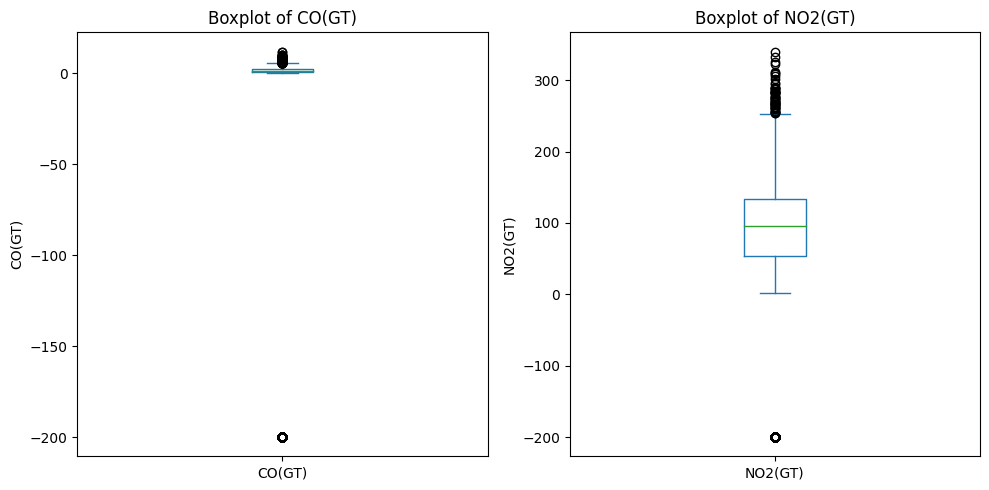

In [67]:
import matplotlib.pyplot as plt

# CO(GT) Boxplots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['CO(GT)'].plot(kind='box', title='Boxplot of CO(GT)')
plt.ylabel('CO(GT)')

# NO2(GT) Boxplots
plt.subplot(1, 2, 2)
df['NO2(GT)'].plot(kind='box', title='Boxplot of NO2(GT)')
plt.ylabel('NO2(GT)')

plt.tight_layout()
plt.show()

In [68]:
# Function to cap outliers based on IQR
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Cap outliers for CO(GT) and NO2(GT)
df = cap_outliers_iqr(df, 'CO(GT)')
df = cap_outliers_iqr(df, 'NO2(GT)')

In [69]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for CO(GT) and NO2(GT)
df = remove_outliers_iqr(df, 'CO(GT)')
df = remove_outliers_iqr(df, 'NO2(GT)')

# Reset index after removing outliers
df.reset_index(drop=True, inplace=True)

In [71]:
from scipy.stats import zscore

# Z-Score Method
def detect_outliers_zscore(data, threshold=3):
    outliers = {}
    for col in data.select_dtypes(include=np.number):  # Numeric columns only
        z_scores = zscore(data[col].dropna())
        outliers[col] = data[col][np.abs(z_scores) > threshold]
    return outliers

# IQR Method
def detect_outliers_iqr(data):
    outliers = {}
    for col in data.select_dtypes(include=np.number):  # Numeric columns only
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = data[col][(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

# Detect outliers using both methods
zscore_outliers = detect_outliers_zscore(df)
iqr_outliers = detect_outliers_iqr(df)

# Print results
print("Outliers detected using Z-Score:")
for col, outlier_values in zscore_outliers.items():
    print(f"{col}: {len(outlier_values)} outliers")

print("\nOutliers detected using IQR:")
for col, outlier_values in iqr_outliers.items():
    print(f"{col}: {len(outlier_values)} outliers")

Outliers detected using Z-Score:
CO(GT): 0 outliers
PT08.S1(CO): 367 outliers
NMHC(GT): 270 outliers
C6H6(GT): 366 outliers
PT08.S2(NMHC): 375 outliers
NOx(GT): 110 outliers
PT08.S3(NOx): 422 outliers
NO2(GT): 0 outliers
PT08.S4(NO2): 366 outliers
PT08.S5(O3): 19 outliers
T: 366 outliers
RH: 366 outliers
AH: 366 outliers
Year: 0 outliers
Month: 0 outliers
Day: 0 outliers

Outliers detected using IQR:
CO(GT): 0 outliers
PT08.S1(CO): 484 outliers
NMHC(GT): 914 outliers
C6H6(GT): 606 outliers
PT08.S2(NMHC): 426 outliers
NOx(GT): 509 outliers
PT08.S3(NOx): 602 outliers
NO2(GT): 0 outliers
PT08.S4(NO2): 450 outliers
PT08.S5(O3): 458 outliers
T: 368 outliers
RH: 366 outliers
AH: 367 outliers
Year: 2247 outliers
Month: 0 outliers
Day: 0 outliers


In [72]:
# Remove outliers using Z-score method
def remove_outliers_zscore(data, threshold=3):
    for col in data.select_dtypes(include=np.number):
        z_scores = zscore(data[col].dropna())
        data = data[np.abs(z_scores) <= threshold]
    return data

# Remove outliers using IQR method
def remove_outliers_iqr(data):
    for col in data.select_dtypes(include=np.number):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

# Example usage
df_cleaned_zscore = remove_outliers_zscore(df.copy())
df_cleaned_iqr = remove_outliers_iqr(df.copy())

print("Dataset after removing outliers (Z-score):", df_cleaned_zscore.shape)
print("Dataset after removing outliers (IQR):", df_cleaned_iqr.shape)

Dataset after removing outliers (Z-score): (8391, 16)
Dataset after removing outliers (IQR): (7262, 16)


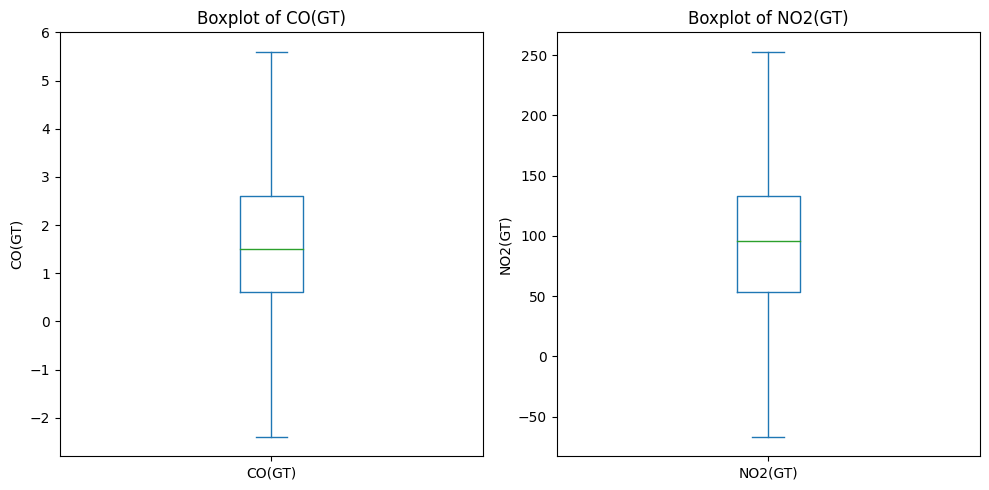

In [73]:
import matplotlib.pyplot as plt

# CO(GT) Boxplots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['CO(GT)'].plot(kind='box', title='Boxplot of CO(GT)')
plt.ylabel('CO(GT)')

# NO2(GT) Boxplots
plt.subplot(1, 2, 2)
df['NO2(GT)'].plot(kind='box', title='Boxplot of NO2(GT)')
plt.ylabel('NO2(GT)')

plt.tight_layout()
plt.show()

Identified Outliers:
Series([], Name: CO(GT), dtype: float64)


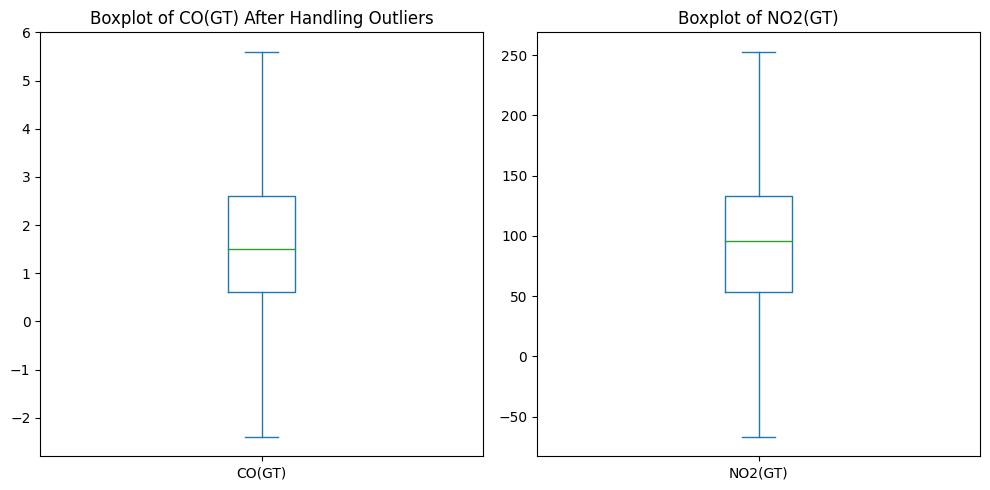

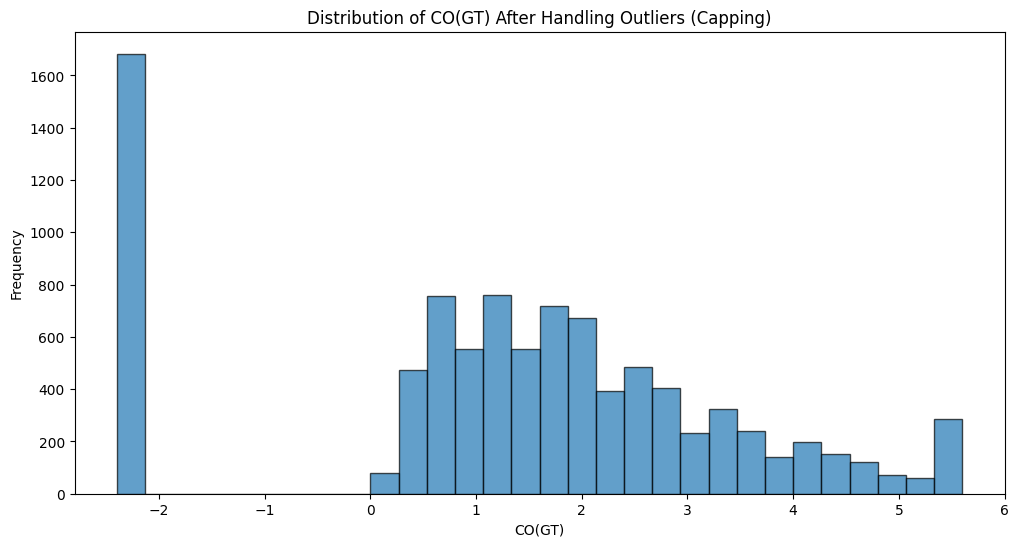

In [74]:
# Adjust Z-Score Threshold for Outlier Detection
z_threshold = 3.5  
df['CO(GT)_zscore'] = zscore(df['CO(GT)'])

# Identify Outliers
outliers = df.loc[abs(df['CO(GT)_zscore']) > z_threshold, 'CO(GT)']
print(f"Identified Outliers:\n{outliers}")

# Cap Outliers Instead of Replacing with Median
Q1 = df['CO(GT)'].quantile(0.25)
Q3 = df['CO(GT)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap values at lower and upper bounds
df['CO(GT)'] = df['CO(GT)'].clip(lower=lower_bound, upper=upper_bound)

# Drop the temporary Z-score column
df.drop(columns=['CO(GT)_zscore'], inplace=True)

# Visualize the Results
# Boxplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['CO(GT)'].plot(kind='box', title='Boxplot of CO(GT) After Handling Outliers')
plt.subplot(1, 2, 2)
df['NO2(GT)'].plot(kind='box', title='Boxplot of NO2(GT)')
plt.tight_layout()
plt.show()

# Histogram for Distribution Check
plt.figure(figsize=(12, 6))
plt.hist(df['CO(GT)'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of CO(GT) After Handling Outliers (Capping)')
plt.xlabel('CO(GT)')
plt.ylabel('Frequency')
plt.show()

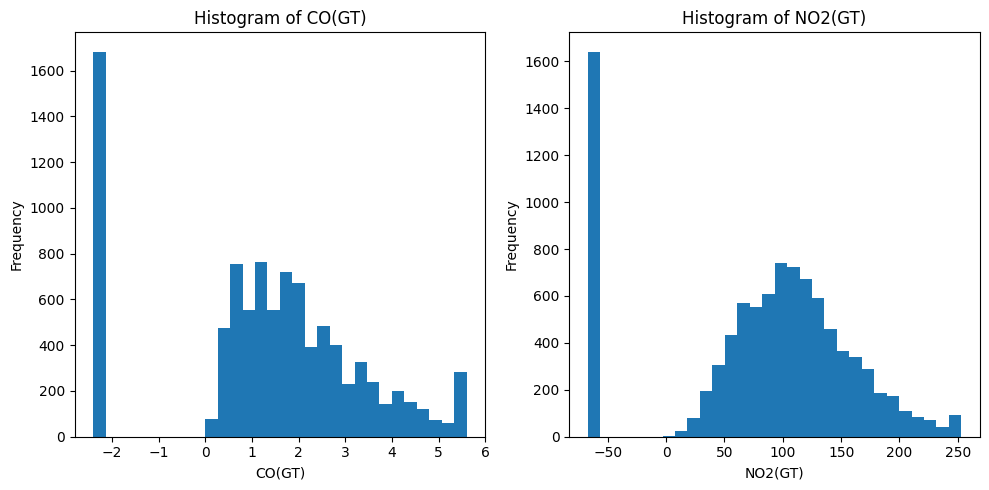

In [75]:
# CO(GT) and NO2(GT) Histplolt
plt.figure(figsize=(10, 5))

# CO(GT) Histplolt
plt.subplot(1, 2, 1)
df['CO(GT)'].plot(kind='hist', bins=30, title='Histogram of CO(GT)')
plt.xlabel('CO(GT)')

# NO2(GT) Histplolt
plt.subplot(1, 2, 2)
df['NO2(GT)'].plot(kind='hist', bins=30, title='Histogram of NO2(GT)')
plt.xlabel('NO2(GT)')

plt.tight_layout()
plt.show()

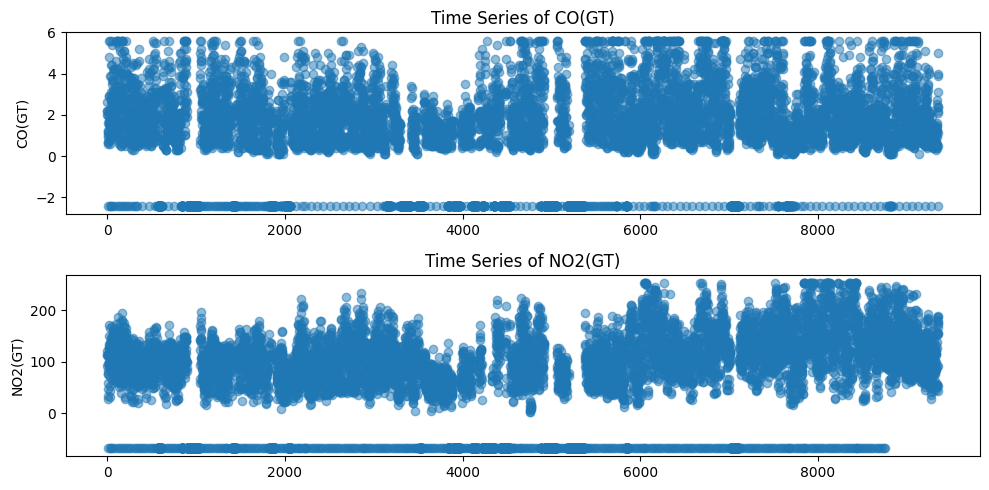

In [76]:
plt.figure(figsize=(10, 5))

# CO(GT) Plot
plt.subplot(2, 1, 1)
plt.plot(df.index, df['CO(GT)'], 'o', alpha=0.5)
plt.title('Time Series of CO(GT)')
plt.ylabel('CO(GT)')

# NO2(GT) Plot
plt.subplot(2, 1, 2)
plt.plot(df.index, df['NO2(GT)'], 'o', alpha=0.5)
plt.title('Time Series of NO2(GT)')
plt.ylabel('NO2(GT)')

plt.tight_layout()
plt.show()

In [77]:
df.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'Year', 'Month', 'Day'],
      dtype='object')

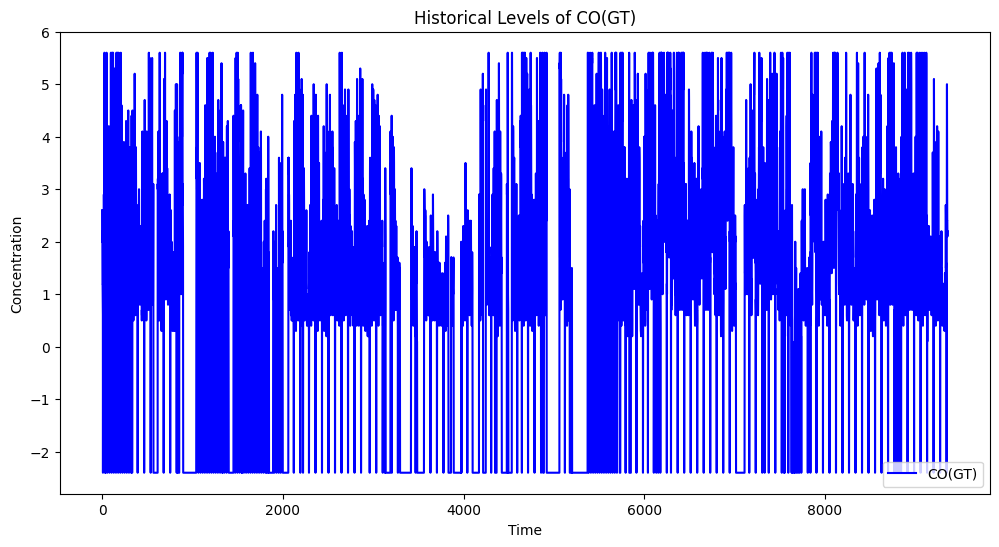

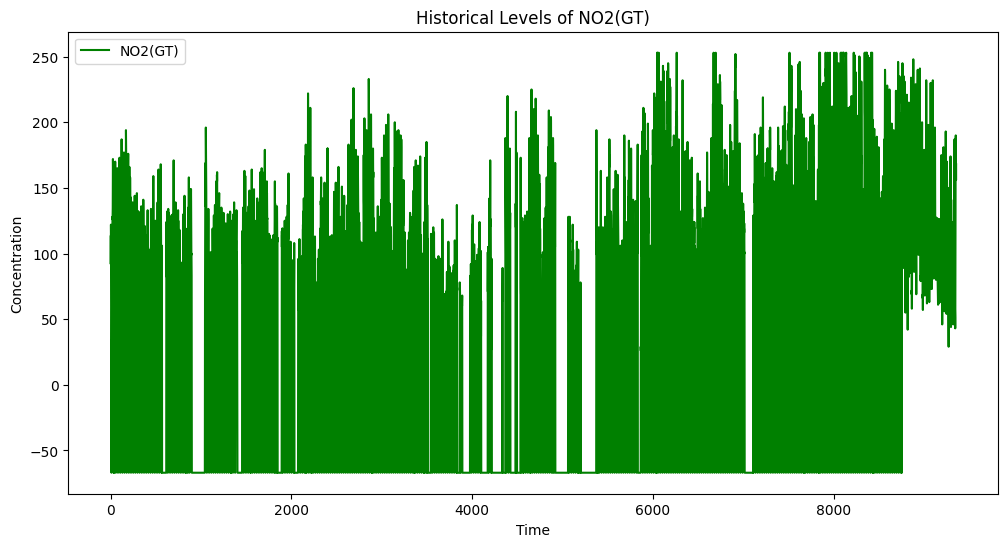

In [78]:
import matplotlib.pyplot as plt

# Plotting CO(GT) historical data
plt.figure(figsize=(12, 6))
plt.plot(df['CO(GT)'], label='CO(GT)', color='blue')
plt.title('Historical Levels of CO(GT)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Plotting NO2(GT) historical data
plt.figure(figsize=(12, 6))
plt.plot(df['NO2(GT)'], label='NO2(GT)', color='green')
plt.title('Historical Levels of NO2(GT)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">2. Exploratory Data Analysis (EDA)</h2>

  ---
- **Trend Analysis**:
  - Visualize the long-term trends of `CO(GT)` and `NO₂(GT)`.
- **Seasonality**:
  - Identify seasonal patterns (e.g., daily or yearly fluctuations).
- **Correlation Analysis**:
  - Explore relationships between `CO(GT)`, `NO₂(GT)`, and other features (e.g., temperature or humidity).

# Performing trend analysis using the same dataset

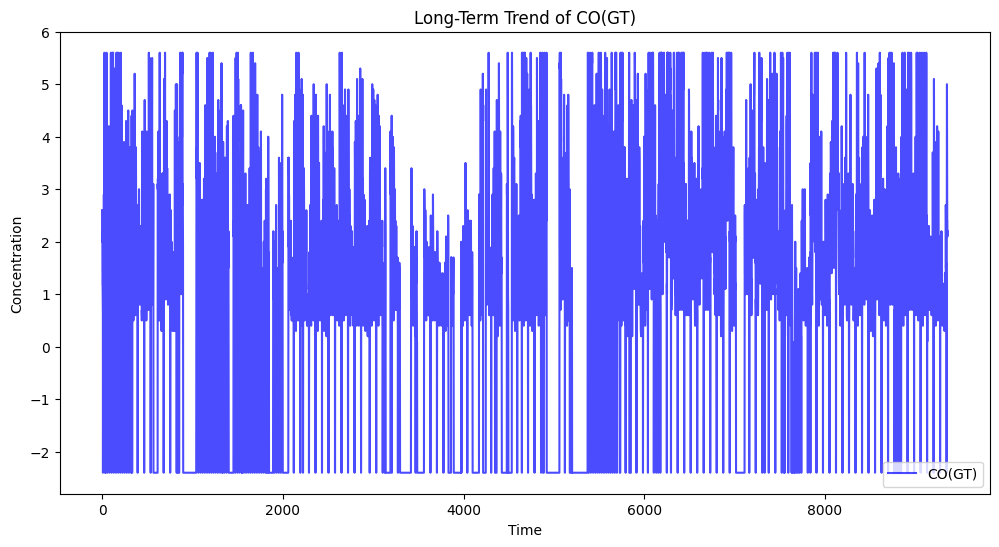

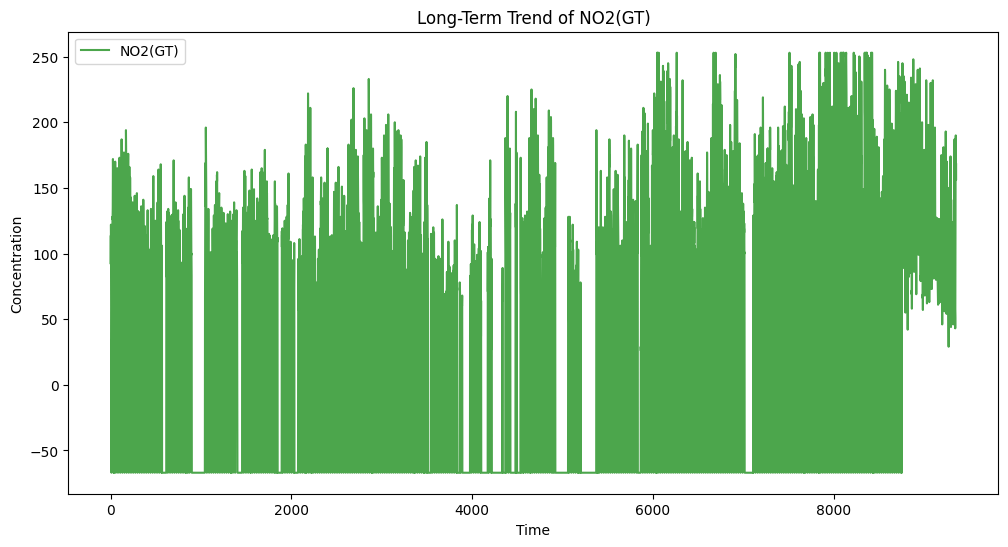

In [79]:
# Plot for CO(GT)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CO(GT)'], label='CO(GT)', color='blue', alpha=0.7)
plt.title('Long-Term Trend of CO(GT)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Plot for NO2(GT)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['NO2(GT)'], label='NO2(GT)', color='green', alpha=0.7)
plt.title('Long-Term Trend of NO2(GT)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

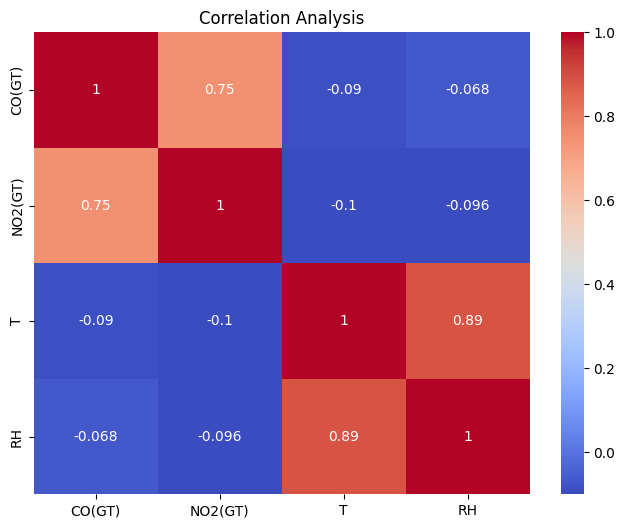

In [80]:
# Correlation between features
correlation = df[['CO(GT)', 'NO2(GT)', 'T', 'RH']].corr()

# Visualize correlation as a heatmap
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis')
plt.show()

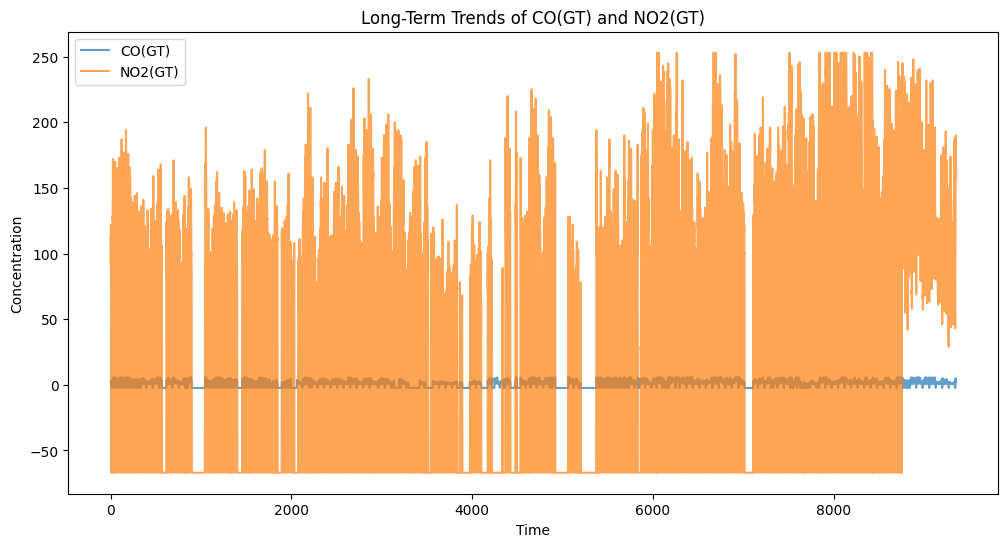

In [81]:
# long-term trends Analysis
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CO(GT)'], label='CO(GT)', alpha=0.7)
plt.plot(df.index, df['NO2(GT)'], label='NO2(GT)', alpha=0.7)
plt.title('Long-Term Trends of CO(GT) and NO2(GT)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [82]:
# print(df['hour'].unique())  # Should show integers from 0 to 23
# print(hourly_mean.head())  # Should show grouped hourly means with index as hours

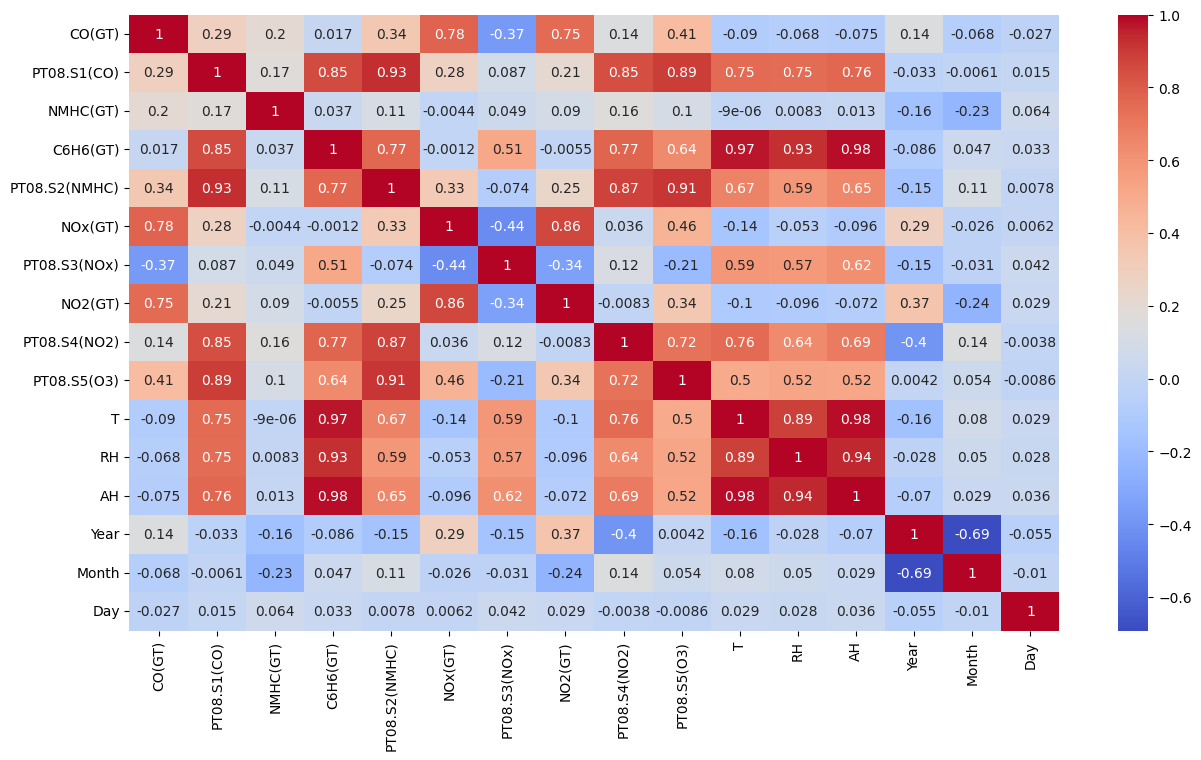

In [83]:
plt.figure(figsize=(15, 8))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

         CO(GT)    NO2(GT)
Month                     
1      1.305579  81.331303


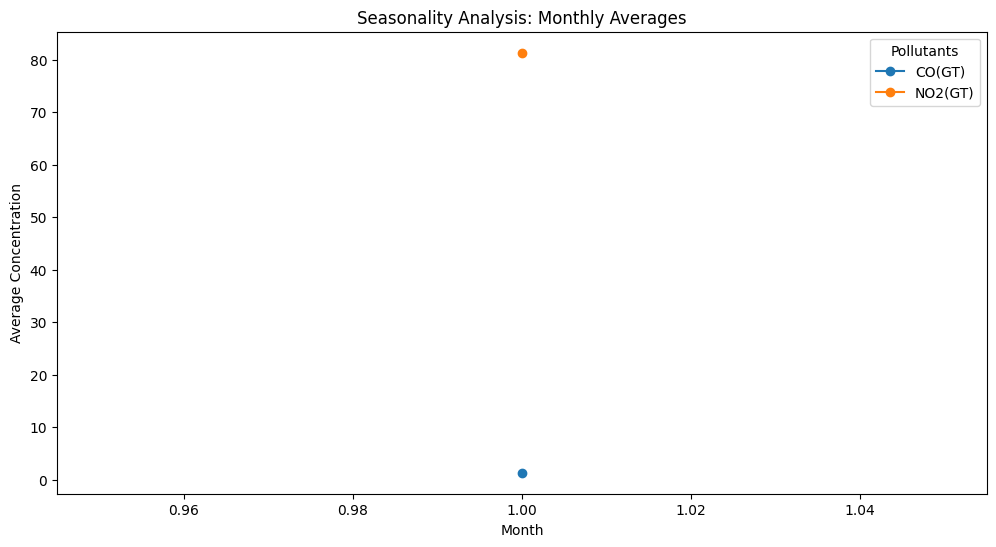

In [84]:
# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)

# Extract the 'month' from the index
df['Month'] = df.index.month

# Group by month and calculate the average
monthly_avg = df.groupby('Month')[['CO(GT)', 'NO2(GT)']].mean()
print(monthly_avg)

# Step 4: Plot the seasonal trends
monthly_avg.plot(figsize=(12, 6), marker='o')
plt.title('Seasonality Analysis: Monthly Averages')
plt.xlabel('Month')
plt.ylabel('Average Concentration')
plt.legend(title='Pollutants')
plt.show()

        CO(GT)    NO2(GT)
Hour                     
0     1.305579  81.331303


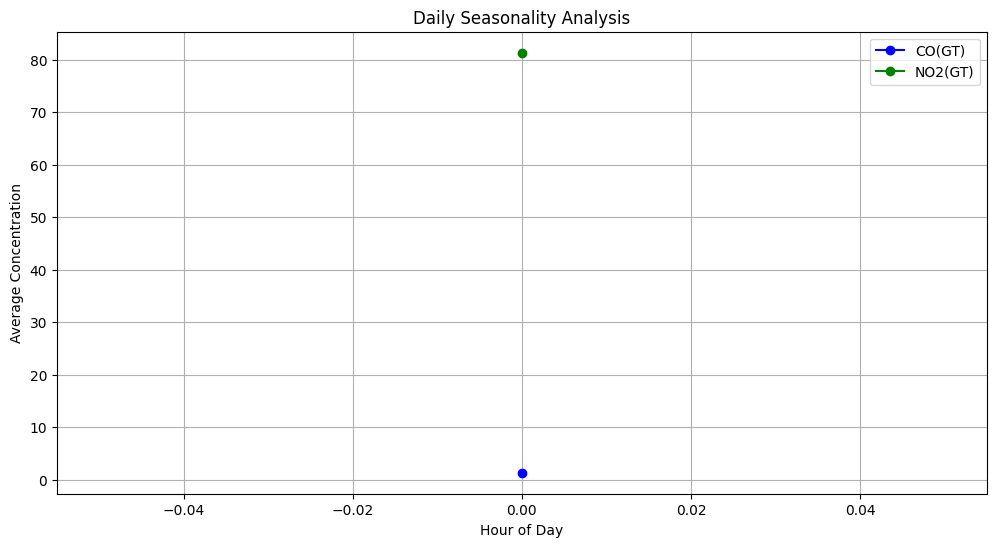

In [85]:
# Convert the index to datetime format
df.index = pd.to_datetime(df.index)

# Create the 'Hour' column
df['Hour'] = df.index.hour

# Calculate hourly averages
hourly_avg = df.groupby('Hour')[['CO(GT)', 'NO2(GT)']].mean()

# Display the hourly averages
print(hourly_avg)

# Step 5: Plot hourly averages
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg['CO(GT)'], label='CO(GT)', marker='o', color='blue')
plt.plot(hourly_avg.index, hourly_avg['NO2(GT)'], label='NO2(GT)', marker='o', color='green')
plt.title('Daily Seasonality Analysis')
plt.xlabel('Hour of Day')
plt.ylabel('Average Concentration')
plt.legend()
plt.grid()
plt.show()

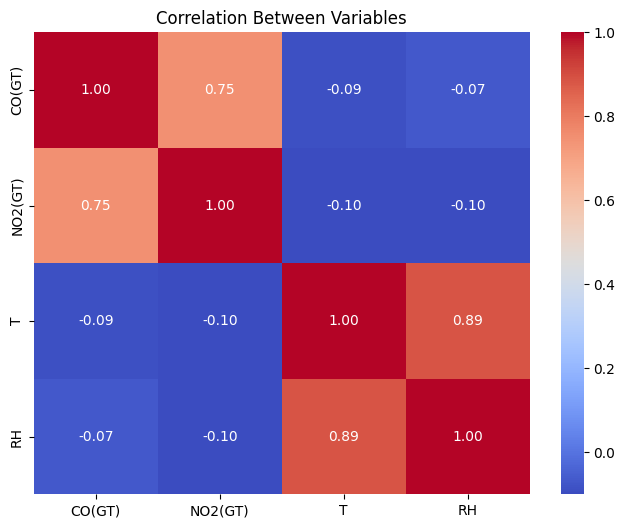

In [86]:
import seaborn as sns

# correlation matrix
correlation_matrix = df[['CO(GT)', 'NO2(GT)', 'T', 'RH']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Variables')
plt.show()

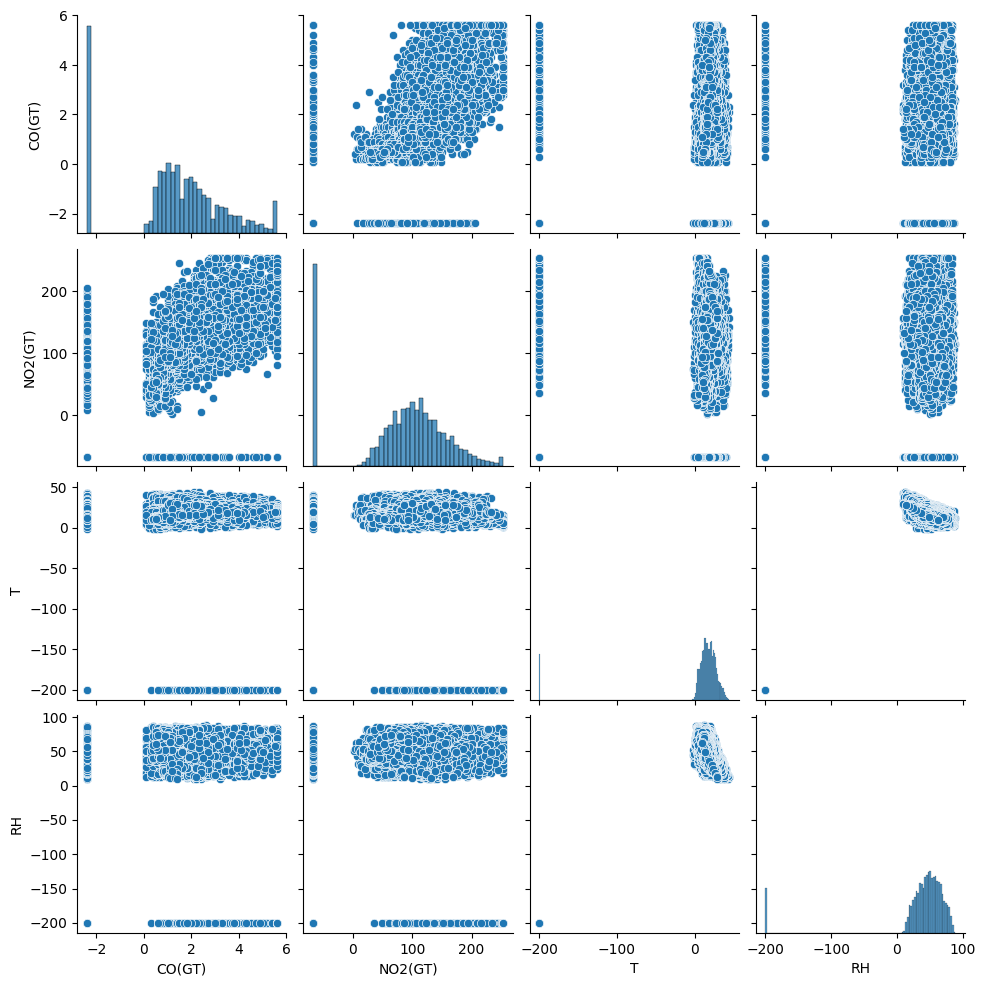

In [87]:
# Pair plot to visualize relationships
sns.pairplot(df[['CO(GT)', 'NO2(GT)', 'T', 'RH']])
plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">3. Feature Engineering</h2>
    
  ---
- Create lag features for `CO(GT)` and `NO₂(GT)` to incorporate historical values.
- Add time-based features (e.g., hour of the day, day of the week, month).
- Include environmental factors (`T`, `RH`, `AH`) as predictors.

In [88]:
# Create lag features for CO(GT) and NO2(GT)
df['CO_lag1'] = df['CO(GT)'].shift(1)
df['CO_lag2'] = df['CO(GT)'].shift(2)

df['NO2_lag1'] = df['NO2(GT)'].shift(1)
df['NO2_lag2'] = df['NO2(GT)'].shift(2)

# Drop rows with NaN values caused by lagging
df = df.dropna()

In [89]:
# Extract time-based features using .loc to modify the original DataFrame
df.loc[:, 'hour'] = df.index.hour
df.loc[:, 'day_of_week'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
df.loc[:, 'month'] = df.index.month

In [90]:
# Ensure predictors are present
predictors = ['T', 'RH', 'AH', 'CO_lag1', 'CO_lag2', 'NO2_lag1', 'NO2_lag2', 'hour', 'day_of_week', 'month']

In [91]:
# Define X (features) and y (target)
X = df[predictors]
y_CO = df['CO(GT)']
y_NO2 = df['NO2(GT)']

# Check the final feature set
print(X.head())

                                  T    RH      AH  CO_lag1  CO_lag2  NO2_lag1  \
1970-01-01 00:00:00.000000002  11.9  54.0  0.7502      2.0      2.6      92.0   
1970-01-01 00:00:00.000000003  11.0  60.0  0.7867      2.2      2.0     114.0   
1970-01-01 00:00:00.000000004  11.2  59.6  0.7888      2.2      2.2     122.0   
1970-01-01 00:00:00.000000005  11.2  59.2  0.7848      1.6      2.2     116.0   
1970-01-01 00:00:00.000000006  11.3  56.8  0.7603      1.2      1.6      96.0   

                               NO2_lag2  hour  day_of_week  month  
1970-01-01 00:00:00.000000002     113.0     0            3      1  
1970-01-01 00:00:00.000000003      92.0     0            3      1  
1970-01-01 00:00:00.000000004     114.0     0            3      1  
1970-01-01 00:00:00.000000005     122.0     0            3      1  
1970-01-01 00:00:00.000000006     116.0     0            3      1  


In [92]:
# Display the first few rows to check lag features
print(df[['CO(GT)', 'CO_lag1', 'CO_lag2', 'NO2(GT)', 'NO2_lag1', 'NO2_lag2']].head(10))

                               CO(GT)  CO_lag1  CO_lag2  NO2(GT)  NO2_lag1  \
1970-01-01 00:00:00.000000002     2.2      2.0      2.6      114      92.0   
1970-01-01 00:00:00.000000003     2.2      2.2      2.0      122     114.0   
1970-01-01 00:00:00.000000004     1.6      2.2      2.2      116     122.0   
1970-01-01 00:00:00.000000005     1.2      1.6      2.2       96     116.0   
1970-01-01 00:00:00.000000006     1.2      1.2      1.6       77      96.0   
1970-01-01 00:00:00.000000007     1.0      1.2      1.2       76      77.0   
1970-01-01 00:00:00.000000008     0.9      1.0      1.2       60      76.0   
1970-01-01 00:00:00.000000009     0.6      0.9      1.0      -67      60.0   
1970-01-01 00:00:00.000000010    -2.4      0.6      0.9       34     -67.0   
1970-01-01 00:00:00.000000011     0.7     -2.4      0.6       28      34.0   

                               NO2_lag2  
1970-01-01 00:00:00.000000002     113.0  
1970-01-01 00:00:00.000000003      92.0  
1970-01-01 00:0

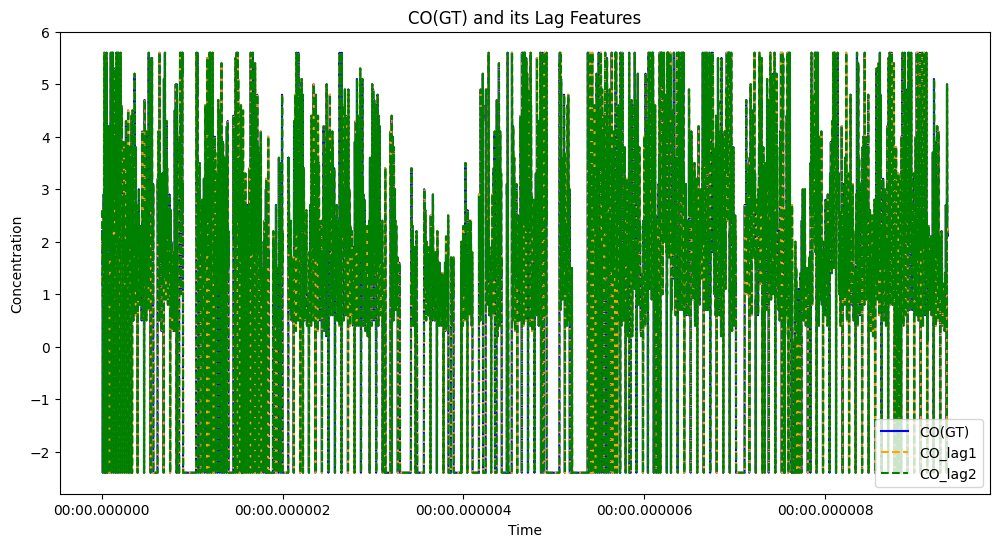

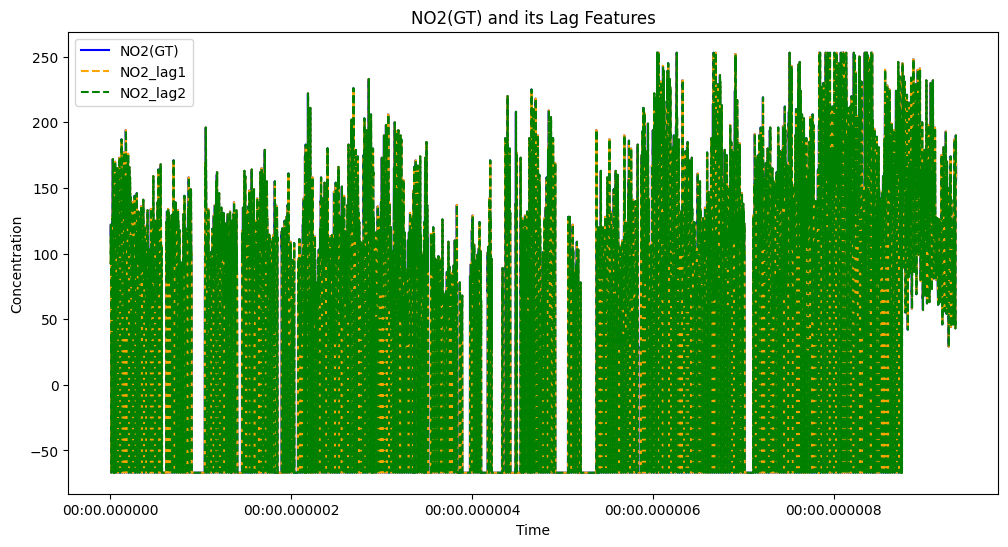

In [93]:
import matplotlib.pyplot as plt

# Plot CO(GT) with its lag features
plt.figure(figsize=(12, 6))
plt.plot(df['CO(GT)'], label='CO(GT)', color='blue')
plt.plot(df['CO_lag1'], label='CO_lag1', color='orange', linestyle='--')
plt.plot(df['CO_lag2'], label='CO_lag2', color='green', linestyle='--')
plt.title('CO(GT) and its Lag Features')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Plot NO2(GT) with its lag features
plt.figure(figsize=(12, 6))
plt.plot(df['NO2(GT)'], label='NO2(GT)', color='blue')
plt.plot(df['NO2_lag1'], label='NO2_lag1', color='orange', linestyle='--')
plt.plot(df['NO2_lag2'], label='NO2_lag2', color='green', linestyle='--')
plt.title('NO2(GT) and its Lag Features')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">4. Time-Series Forecasting</h2>


  ---
- Train separate models for **CO(GT)** and **NO₂(GT)**.
- Explore the following forecasting approaches:
  - **Statistical Models**:
    - Classical models like ARIMA or SARIMA for univariate forecasting.
  - **Machine Learning Models**:
    - Use regression models trained on lag features and external predictors.
  - **Deep Learning Models**:
    - Apply LSTM, GRU, or other RNN-based models for sequence forecasting.
- Evaluate and compare the models.

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">Steps for SARIMA Model Preparation and Implementation</h2>

---

### Step 1: Preparing the Dataset
- **Stationarity**: Ensure that the data is stationary by performing stationarity tests (e.g., ADF test).
- **Seasonality**: Properly capture seasonality and trends in the data.
- **Train-Test Split**: Split the dataset into training and testing sets.

### Step 2: Parameter Selection for SARIMA Model
- Identify the parameters \( p, d, q, P, D, Q, s \) for the SARIMA model.

### Step 3: Build the SARIMA Model
- Fit the SARIMA model using the parameters obtained (e.g., from Auto ARIMA).

### Step 4: Forecasting
- Generate separate forecasts for **CO** and **NO2** levels.

### Step 5: Evaluation
- Evaluate the performance of the forecasts using appropriate metrics (e.g., RMSE, MAE).

In [94]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity for CO(GT)
result_co = adfuller(df['CO(GT)'])
print("CO(GT) - ADF Statistic:", result_co[0])
print("CO(GT) - p-value:", result_co[1])

# Check stationarity for NO2(GT)
result_no2 = adfuller(df['NO2(GT)'])
print("NO2(GT) - ADF Statistic:", result_no2[0])
print("NO2(GT) - p-value:", result_no2[1])


CO(GT) - ADF Statistic: -9.480388196790125
CO(GT) - p-value: 3.887056564881024e-16
NO2(GT) - ADF Statistic: -8.347870071648714
NO2(GT) - p-value: 3.0506071286123203e-13


In [95]:
# Differencing if needed
df['CO_diff'] = df['CO(GT)'].diff().dropna()
df['NO2_diff'] = df['NO2(GT)'].diff().dropna()

In [96]:
from pmdarima import auto_arima

# Auto ARIMA for CO(GT)
auto_arima_co = auto_arima(df['CO(GT)'], seasonal=True, m=12)
print(auto_arima_co.summary())

# Auto ARIMA for NO2(GT)
auto_arima_no2 = auto_arima(df['NO2(GT)'], seasonal=True, m=12)
print(auto_arima_no2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 9355
Model:             SARIMAX(4, 1, 1)x(2, 0, [], 12)   Log Likelihood              -12338.402
Date:                             Fri, 10 Jan 2025   AIC                          24694.804
Time:                                     09:16:46   BIC                          24759.096
Sample:                                 01-01-1970   HQIC                         24716.639
                                      - 01-01-1970                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.943e-06      0.000      0.016      0.987      -0.000       0.000
ar.L1          0.7614      

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model for CO(GT)
sarima_co = SARIMAX(df['CO(GT)'], 
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 12))
sarima_co_fit = sarima_co.fit()
print(sarima_co_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             CO(GT)   No. Observations:                 9355
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -12095.368
Date:                            Fri, 10 Jan 2025   AIC                          24200.737
Time:                                    09:28:55   BIC                          24236.448
Sample:                                01-01-1970   HQIC                         24212.866
                                     - 01-01-1970                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7549      0.010     77.393      0.000       0.736       0.774
ma.L1         -0.9230      0.007   

In [98]:
# Fit SARIMA model for NO2(GT)
sarima_no2 = SARIMAX(df['NO2(GT)'], 
                     order=(1, 1, 1), 
                     seasonal_order=(1, 1, 1, 12))
sarima_no2_fit = sarima_no2.fit()
print(sarima_no2_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            NO2(GT)   No. Observations:                 9355
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -45309.893
Date:                            Fri, 10 Jan 2025   AIC                          90629.785
Time:                                    09:29:29   BIC                          90665.497
Sample:                                01-01-1970   HQIC                         90641.915
                                     - 01-01-1970                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4577      0.015     29.682      0.000       0.427       0.488
ma.L1         -0.7267      0.014   

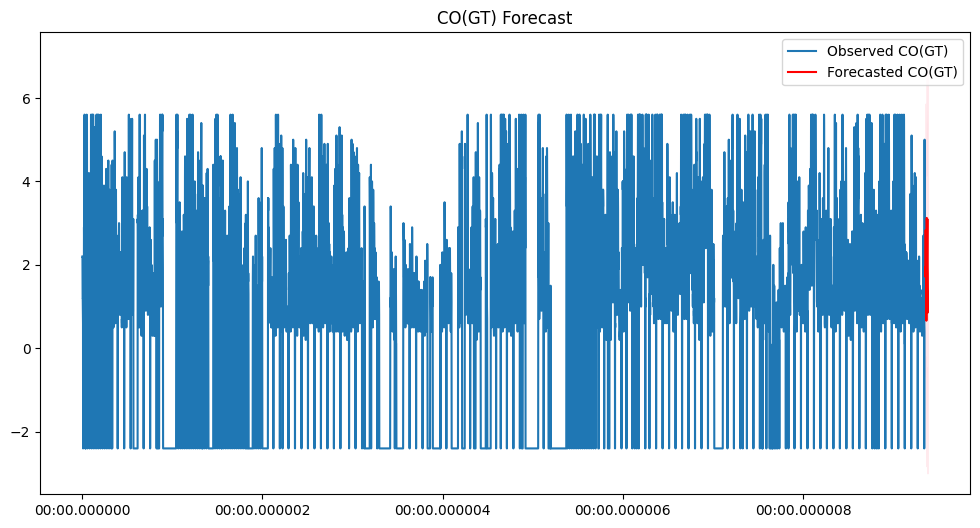

In [99]:
forecast_co = sarima_co_fit.get_forecast(steps=30)
forecast_co_values = forecast_co.predicted_mean
forecast_co_ci = forecast_co.conf_int()

# Plot CO(GT) Forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['CO(GT)'], label='Observed CO(GT)')
plt.plot(forecast_co_values, label='Forecasted CO(GT)', color='red')
plt.fill_between(forecast_co_values.index, 
                 forecast_co_ci.iloc[:, 0], 
                 forecast_co_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('CO(GT) Forecast')
plt.show()

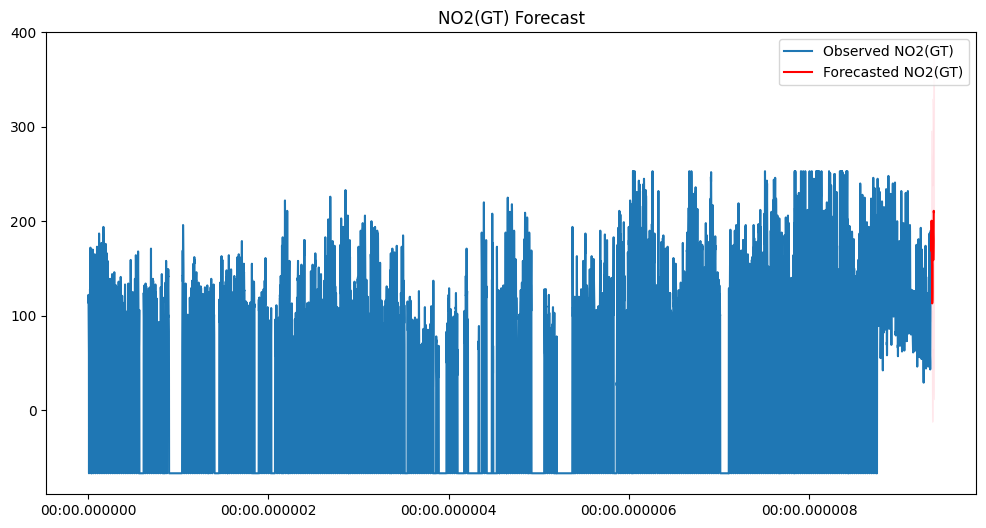

In [100]:
forecast_no2 = sarima_no2_fit.get_forecast(steps=30)
forecast_no2_values = forecast_no2.predicted_mean
forecast_no2_ci = forecast_no2.conf_int()

# Plot NO2(GT) Forecast
plt.figure(figsize=(12, 6))
plt.plot(df['NO2(GT)'], label='Observed NO2(GT)')
plt.plot(forecast_no2_values, label='Forecasted NO2(GT)', color='red')
plt.fill_between(forecast_no2_values.index, 
                 forecast_no2_ci.iloc[:, 0], 
                 forecast_no2_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('NO2(GT) Forecast')
plt.show()

In [101]:
from sklearn.metrics import mean_squared_error

# RMSE for CO(GT)
rmse_co = mean_squared_error(df['CO(GT)'].iloc[-30:], forecast_co_values, squared=False)
print("RMSE for CO(GT):", rmse_co)

# RMSE for NO2(GT)
rmse_no2 = mean_squared_error(df['NO2(GT)'].iloc[-30:], forecast_no2_values, squared=False)
print("RMSE for NO2(GT):", rmse_no2)

RMSE for CO(GT): 1.7170444694982114
RMSE for NO2(GT): 75.51717811981611


<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">Steps to Build LSTM Models for CO(GT) and NO2(GT)</h2>


---

## Step 1: Import Libraries

## Step 2: Data Preparation

## Step 3: Create Time Series Data
- Create sequences for training and testing.
    - **Function to create sequences for LSTM**
    - **Create sequences for CO(GT)**
    - **Create sequences for NO2(GT)**
    - **Reshape inputs for LSTM**

## Step 4: Train-Test Split
- Split data into training and testing sets.
    - **Split data for CO(GT)**
    - **Split data for NO2(GT)**

## Step 5: Build LSTM Models
### For CO(GT):
- **LSTM model for CO(GT)**
- **Train the model**

### For NO2(GT):
- **LSTM model for NO2(GT)**
- **Train the model**

## Step 6: Evaluate Models
- Plot training and validation loss.
    - **Plot for CO(GT)**
    - **Plot for NO2(GT)**

## Step 7: Make Predictions
- Predict using the trained models and inverse transform to get the actual values.

### For CO(GT):
- **Predict on test data**
- **Plot CO(GT) Predictions**

### For NO2(GT):
- **Predict on test data**
- **Plot NO2(GT) Predictions**

In [102]:
# Select columns for CO(GT) and NO2(GT)
data_co = df[['CO(GT)']].dropna()
data_no2 = df[['NO2(GT)']].dropna()

# Normalize the data
scaler_co = MinMaxScaler(feature_range=(0, 1))
scaled_co = scaler_co.fit_transform(data_co)

scaler_no2 = MinMaxScaler(feature_range=(0, 1))
scaled_no2 = scaler_no2.fit_transform(data_no2)

In [103]:
# Function to create sequences for LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

# Create sequences for CO(GT)
time_steps = 30
X_co, y_co = create_sequences(scaled_co, time_steps)

# Create sequences for NO2(GT)
X_no2, y_no2 = create_sequences(scaled_no2, time_steps)

# Reshape inputs for LSTM
X_co = X_co.reshape((X_co.shape[0], X_co.shape[1], 1))
X_no2 = X_no2.reshape((X_no2.shape[0], X_no2.shape[1], 1))

In [104]:
# Split data for CO(GT)
train_size_co = int(len(X_co) * 0.8)
X_train_co, X_test_co = X_co[:train_size_co], X_co[train_size_co:]
y_train_co, y_test_co = y_co[:train_size_co], y_co[train_size_co:]

# Split data for NO2(GT)
train_size_no2 = int(len(X_no2) * 0.8)
X_train_no2, X_test_no2 = X_no2[:train_size_no2], X_no2[train_size_no2:]
y_train_no2, y_test_no2 = y_no2[:train_size_no2], y_no2[train_size_no2:]

In [105]:
# LSTM model for CO(GT)
model_co = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(50),
    Dense(1)
])

model_co.compile(optimizer='adam', loss='mse')
# Train the model
history_co = model_co.fit(X_train_co, y_train_co, epochs=20, batch_size=32, validation_data=(X_test_co, y_test_co), verbose=1)

Epoch 1/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0468 - val_loss: 0.0195
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0192 - val_loss: 0.0134
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0154 - val_loss: 0.0129
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0139 - val_loss: 0.0116
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0148 - val_loss: 0.0115
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0140 - val_loss: 0.0116
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0146 - val_loss: 0.0110
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0139 - val_loss: 0.0111
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122 - val_loss: 0.0104
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0141 - val_loss: 0.0106
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132 - val_loss: 0.0107
Epoch 12/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [106]:
# LSTM model for NO2(GT)
model_no2 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(50),
    Dense(1)
])

model_no2.compile(optimizer='adam', loss='mse')
# Train the model
history_no2 = model_no2.fit(X_train_no2, y_train_no2, epochs=20, batch_size=32, validation_data=(X_test_no2, y_test_no2), verbose=1)

Epoch 1/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0485 - val_loss: 0.0273
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0181 - val_loss: 0.0219
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0150 - val_loss: 0.0185
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0137 - val_loss: 0.0172
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0125 - val_loss: 0.0149
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114 - val_loss: 0.0148
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - val_loss: 0.0142
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0105 - val_loss: 0.0163
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0102 - val_loss: 0.0162
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0100 - val_loss: 0.0174
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - val_loss: 0.0127
Epoch 12/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

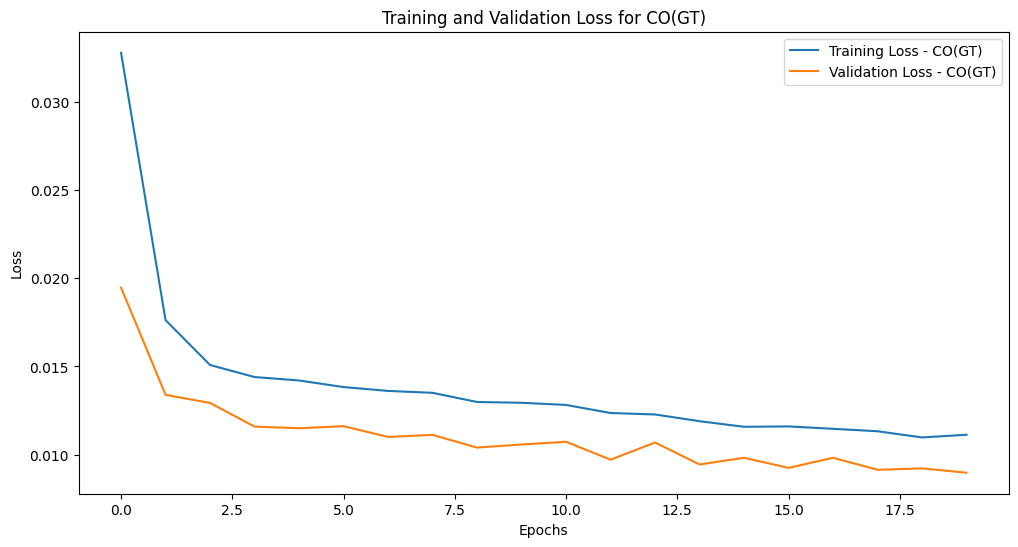

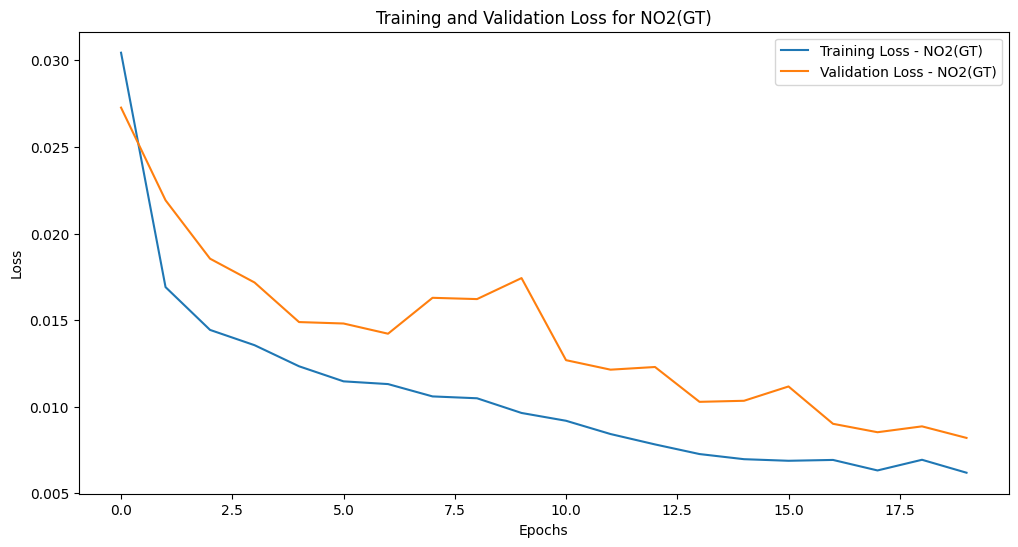

In [107]:
# Plot for CO(GT)
plt.figure(figsize=(12, 6))
plt.plot(history_co.history['loss'], label='Training Loss - CO(GT)')
plt.plot(history_co.history['val_loss'], label='Validation Loss - CO(GT)')
plt.title('Training and Validation Loss for CO(GT)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot for NO2(GT)
plt.figure(figsize=(12, 6))
plt.plot(history_no2.history['loss'], label='Training Loss - NO2(GT)')
plt.plot(history_no2.history['val_loss'], label='Validation Loss - NO2(GT)')
plt.title('Training and Validation Loss for NO2(GT)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


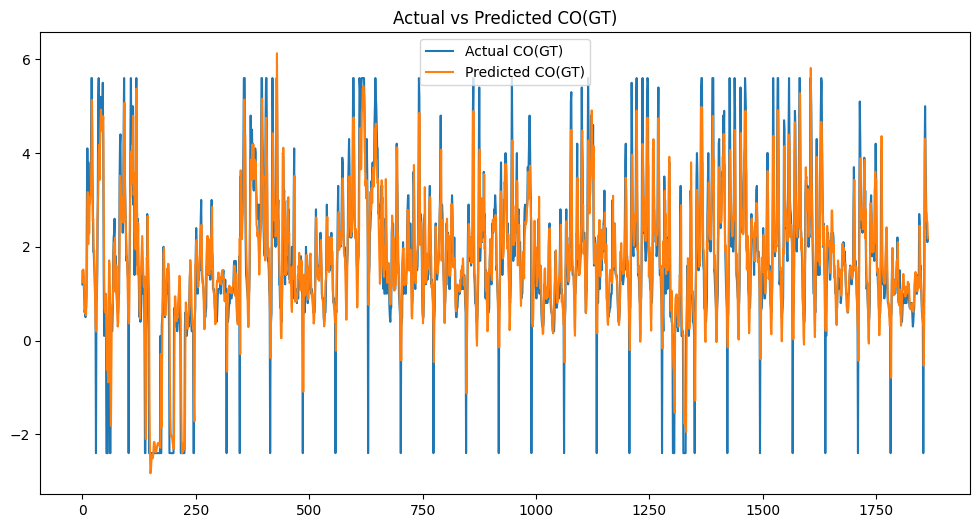

In [108]:
# Predict on test data
predicted_co = model_co.predict(X_test_co)
predicted_co = scaler_co.inverse_transform(predicted_co.reshape(-1, 1))
y_test_co_actual = scaler_co.inverse_transform(y_test_co.reshape(-1, 1))

# Plot CO(GT) Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_co_actual, label='Actual CO(GT)')
plt.plot(predicted_co, label='Predicted CO(GT)')
plt.title('Actual vs Predicted CO(GT)')
plt.legend()
plt.show()

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


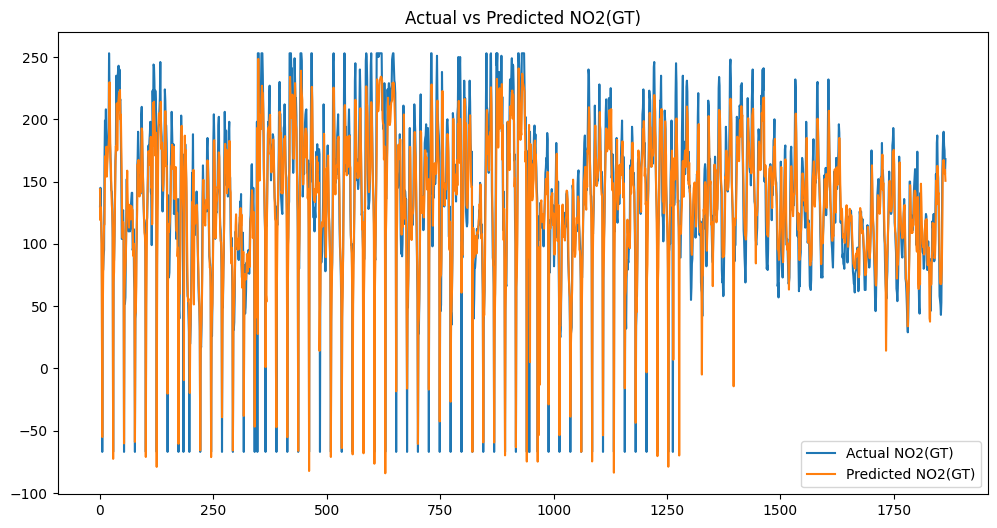

In [109]:
# Predict on test data
predicted_no2 = model_no2.predict(X_test_no2)
predicted_no2 = scaler_no2.inverse_transform(predicted_no2.reshape(-1, 1))
y_test_no2_actual = scaler_no2.inverse_transform(y_test_no2.reshape(-1, 1))

# Plot NO2(GT) Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_no2_actual, label='Actual NO2(GT)')
plt.plot(predicted_no2, label='Predicted NO2(GT)')
plt.title('Actual vs Predicted NO2(GT)')
plt.legend()
plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">Build GRU models for predicting CO(GT) and NO2(GT)</h2>

In [110]:
# Select columns for CO(GT) and NO2(GT)
data_co = df[['CO(GT)']].dropna()
data_no2 = df[['NO2(GT)']].dropna()

# Normalize the data
scaler_co = MinMaxScaler(feature_range=(0, 1))
scaled_co = scaler_co.fit_transform(data_co)

scaler_no2 = MinMaxScaler(feature_range=(0, 1))
scaled_no2 = scaler_no2.fit_transform(data_no2)

In [111]:
# Function to create sequences for GRU
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

# Create sequences for CO(GT)
time_steps = 30
X_co, y_co = create_sequences(scaled_co, time_steps)

# Create sequences for NO2(GT)
X_no2, y_no2 = create_sequences(scaled_no2, time_steps)

# Reshape inputs for GRU
X_co = X_co.reshape((X_co.shape[0], X_co.shape[1], 1))
X_no2 = X_no2.reshape((X_no2.shape[0], X_no2.shape[1], 1))

In [112]:
# Split data for CO(GT)
train_size_co = int(len(X_co) * 0.8)
X_train_co, X_test_co = X_co[:train_size_co], X_co[train_size_co:]
y_train_co, y_test_co = y_co[:train_size_co], y_co[train_size_co:]

# Split data for NO2(GT)
train_size_no2 = int(len(X_no2) * 0.8)
X_train_no2, X_test_no2 = X_no2[:train_size_no2], X_no2[train_size_no2:]
y_train_no2, y_test_no2 = y_no2[:train_size_no2], y_no2[train_size_no2:]

In [113]:
# GRU model for CO(GT)
model_co = Sequential([
    GRU(50, return_sequences=True, input_shape=(time_steps, 1)),
    GRU(50),
    Dense(1)
])

model_co.compile(optimizer='adam', loss='mse')
# Train the model
history_co = model_co.fit(X_train_co, y_train_co, epochs=20, batch_size=32, validation_data=(X_test_co, y_test_co), verbose=1)

Epoch 1/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0517 - val_loss: 0.0133
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0147 - val_loss: 0.0126
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0148 - val_loss: 0.0120
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0148 - val_loss: 0.0118
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0138 - val_loss: 0.0118
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0146 - val_loss: 0.0119
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0141 - val_loss: 0.0112
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0137 - val_loss: 0.0113
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0131 - val_loss: 0.0118
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0148 - val_loss: 0.0107
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0120 - val_loss: 0.0102
Epoch 12/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [114]:
# GRU model for NO2(GT)
model_no2 = Sequential([
    GRU(50, return_sequences=True, input_shape=(time_steps, 1)),
    GRU(50),
    Dense(1)
])

model_no2.compile(optimizer='adam', loss='mse')
# Train the model
history_no2 = model_no2.fit(X_train_no2, y_train_no2, epochs=20, batch_size=32, validation_data=(X_test_no2, y_test_no2), verbose=1)

Epoch 1/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0355 - val_loss: 0.0223
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0162 - val_loss: 0.0202
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0137 - val_loss: 0.0182
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0135 - val_loss: 0.0196
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119 - val_loss: 0.0161
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0126 - val_loss: 0.0157
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107 - val_loss: 0.0160
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - val_loss: 0.0203
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - val_loss: 0.0224
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080 - val_loss: 0.0321
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - val_loss: 0.0325
Epoch 12/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

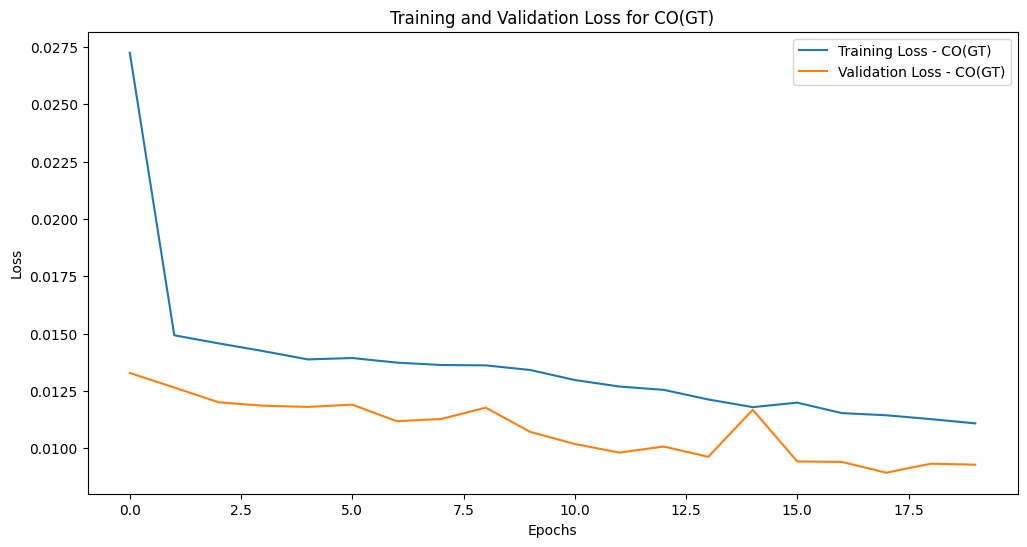

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(history_co.history['loss'], label='Training Loss - CO(GT)')
plt.plot(history_co.history['val_loss'], label='Validation Loss - CO(GT)')
plt.title('Training and Validation Loss for CO(GT)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

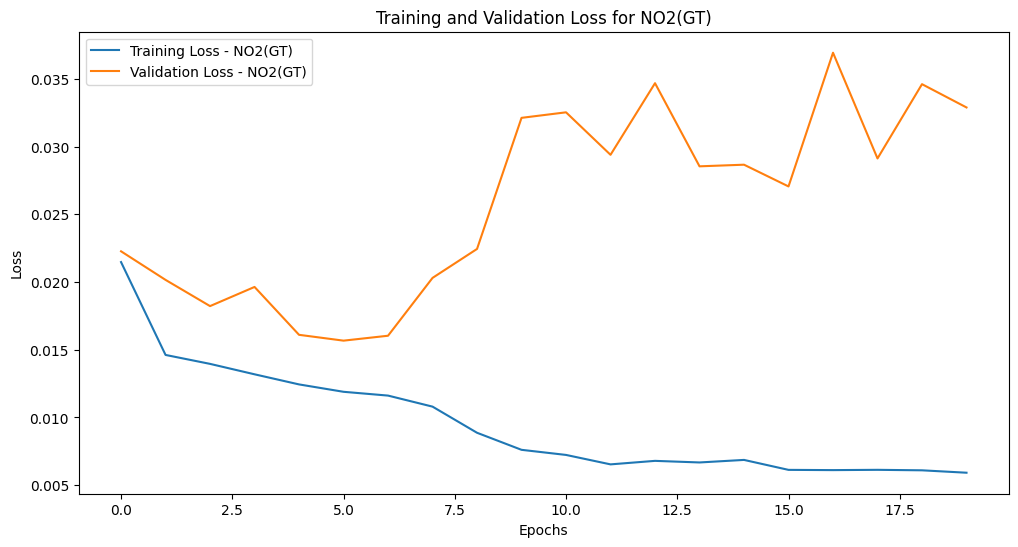

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(history_no2.history['loss'], label='Training Loss - NO2(GT)')
plt.plot(history_no2.history['val_loss'], label='Validation Loss - NO2(GT)')
plt.title('Training and Validation Loss for NO2(GT)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### For CO(GT)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


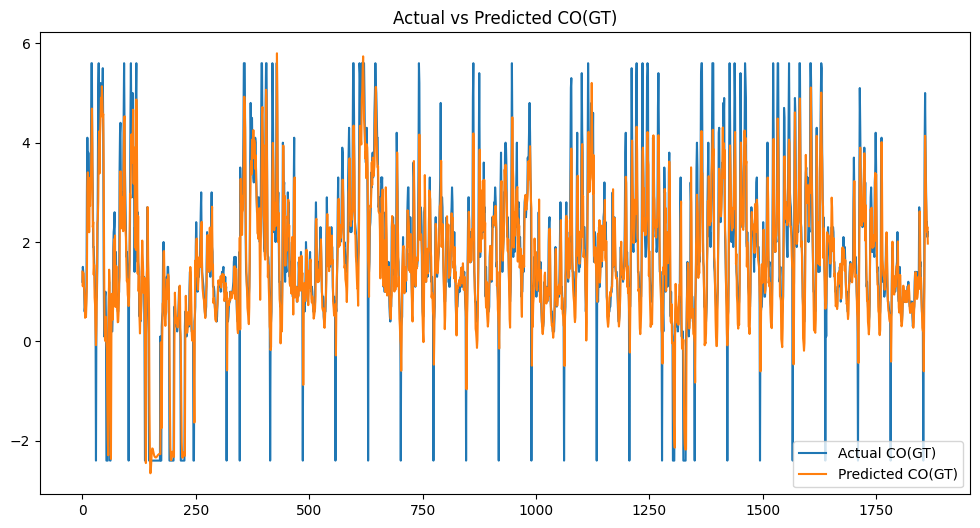

In [117]:
# Predict on test data
predicted_co = model_co.predict(X_test_co)
predicted_co = scaler_co.inverse_transform(predicted_co.reshape(-1, 1))
y_test_co_actual = scaler_co.inverse_transform(y_test_co.reshape(-1, 1))

# Plot CO(GT) Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_co_actual, label='Actual CO(GT)')
plt.plot(predicted_co, label='Predicted CO(GT)')
plt.title('Actual vs Predicted CO(GT)')
plt.legend()
plt.show()

### For NO2(GT)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


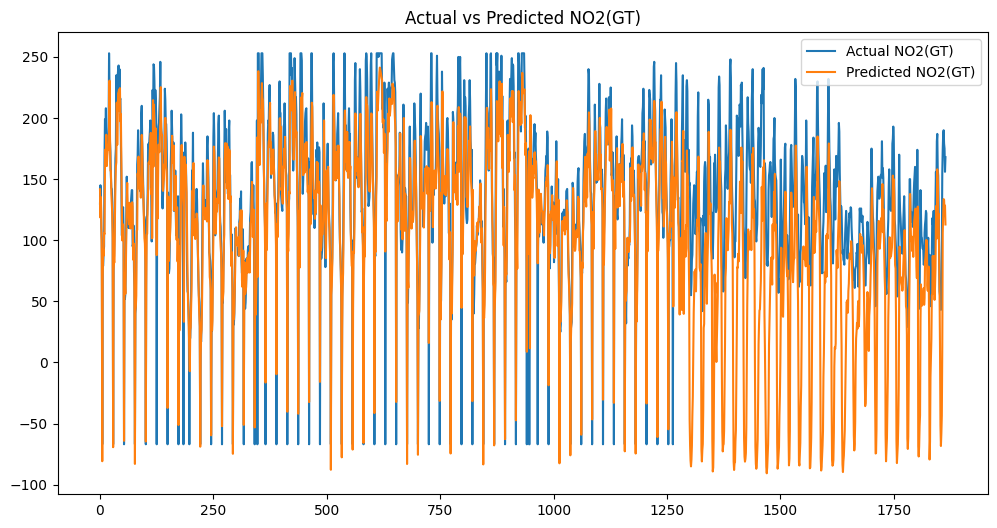

In [118]:
# Predict on test data
predicted_no2 = model_no2.predict(X_test_no2)
predicted_no2 = scaler_no2.inverse_transform(predicted_no2.reshape(-1, 1))
y_test_no2_actual = scaler_no2.inverse_transform(y_test_no2.reshape(-1, 1))

# Plot NO2(GT) Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_no2_actual, label='Actual NO2(GT)')
plt.plot(predicted_no2, label='Predicted NO2(GT)')
plt.title('Actual vs Predicted NO2(GT)')
plt.legend()
plt.show()

In [120]:
print(df.columns)

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'Year', 'Month', 'Day', 'Hour', 'CO_lag1', 'CO_lag2',
       'NO2_lag1', 'NO2_lag2', 'hour', 'day_of_week', 'month', 'CO_diff',
       'NO2_diff'],
      dtype='object')


In [121]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity in the 'CO(GT)' column
result = adfuller(df['CO(GT)'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("The series is not stationary. Differencing will be applied.")
    df['CO(GT)_Diff'] = df['CO(GT)'].diff().dropna()
else:
    print("The series is stationary. Proceeding without differencing.")


ADF Statistic: -9.480388196790125
p-value: 3.887056564881024e-16
The series is stationary. Proceeding without differencing.


In [124]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(df['CO(GT)'], order=(1, 1, 1))  # Replace with the correct column name
arima_fitted = model.fit()

# Forecast future values
forecast_steps = 20
forecast = arima_fitted.forecast(steps=forecast_steps)

# Print the forecast
print("ARIMA Forecast:\n", forecast)

ARIMA Forecast:
 1970-01-01 00:00:00.000009357    2.079085
1970-01-01 00:00:00.000009358    1.982270
1970-01-01 00:00:00.000009359    1.904750
1970-01-01 00:00:00.000009360    1.842681
1970-01-01 00:00:00.000009361    1.792983
1970-01-01 00:00:00.000009362    1.753191
1970-01-01 00:00:00.000009363    1.721329
1970-01-01 00:00:00.000009364    1.695818
1970-01-01 00:00:00.000009365    1.675391
1970-01-01 00:00:00.000009366    1.659036
1970-01-01 00:00:00.000009367    1.645940
1970-01-01 00:00:00.000009368    1.635455
1970-01-01 00:00:00.000009369    1.627059
1970-01-01 00:00:00.000009370    1.620337
1970-01-01 00:00:00.000009371    1.614954
1970-01-01 00:00:00.000009372    1.610645
1970-01-01 00:00:00.000009373    1.607194
1970-01-01 00:00:00.000009374    1.604431
1970-01-01 00:00:00.000009375    1.602219
1970-01-01 00:00:00.000009376    1.600447
Freq: N, Name: predicted_mean, dtype: float64


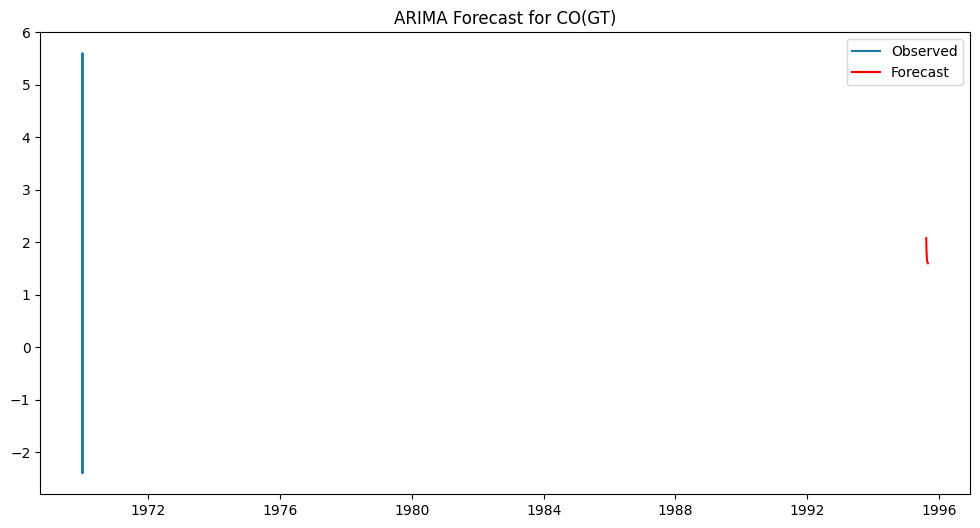

In [127]:
# Plot the forecast
import matplotlib.pyplot as plt

# Replace 'CO(GT)' with your actual column name
plt.figure(figsize=(12, 6))
plt.plot(df['CO(GT)'], label='Observed')  # Observed data
plt.plot(range(len(df), len(df) + forecast_steps), forecast, label='Forecast', color='red')  # Forecasted data
plt.legend()
plt.title('ARIMA Forecast for CO(GT)')
plt.show()

In [131]:
# Assign co_series to a column in the DataFrame
co_series = df['CO(GT)']  # Replace 'CO(GT)' with your desired column name

# Check the first few rows and total number of data points
print(co_series.head())  # First few rows
print(len(co_series))    # Total number of data points

# Check for missing values and handle them
print("Number of missing values:", co_series.isnull().sum())  # Check NaNs
co_series = co_series.dropna()  # Drop NaN values

# Verify the updated series
print("Number of data points after dropping NaNs:", len(co_series))

1970-01-01 00:00:00.000000002    2.2
1970-01-01 00:00:00.000000003    2.2
1970-01-01 00:00:00.000000004    1.6
1970-01-01 00:00:00.000000005    1.2
1970-01-01 00:00:00.000000006    1.2
Name: CO(GT), dtype: float64
9355
Number of missing values: 0
Number of data points after dropping NaNs: 9355


In [132]:
co_series_diff = co_series.diff().dropna()
print(co_series_diff.head())  # Ensure it has data
print(len(co_series_diff))  # Check the number of data points

1970-01-01 00:00:00.000000003    0.0
1970-01-01 00:00:00.000000004   -0.6
1970-01-01 00:00:00.000000005   -0.4
1970-01-01 00:00:00.000000006    0.0
1970-01-01 00:00:00.000000007   -0.2
Name: CO(GT), dtype: float64
9354


#### Machine Learning Models (Lag Features)

Random Forest - MAE: 2.7380, RMSE: 3.2156, R²: -0.6818


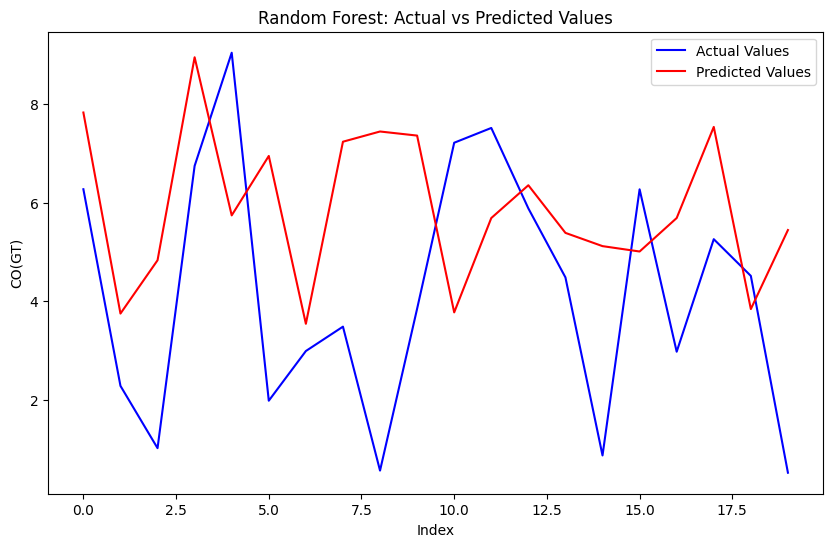

In [133]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Simulate or use your dataset
timestamps = pd.date_range(start='2023-01-01', periods=100, freq='D')
df = pd.DataFrame({'CO(GT)': np.random.rand(100) * 10}, index=timestamps)

# Create lag features
df['CO_lag1'] = df['CO(GT)'].shift(1)

# Drop rows with NaN values
ml_data = df.dropna().copy()

# Ensure there is enough data
if ml_data.empty or len(ml_data) < 5:
    print("Not enough data points after creating lag features. Using simulated data for testing.")
    timestamps = pd.date_range(start='2023-01-01', periods=50, freq='D')
    df = pd.DataFrame({'CO(GT)': np.random.rand(50) * 10}, index=timestamps)
    df['CO_lag1'] = df['CO(GT)'].shift(1)
    ml_data = df.dropna().copy()

# Define feature matrix X and target variable y
X = ml_data[['CO_lag1']]
y = ml_data['CO(GT)']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red')
plt.title('Random Forest: Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('CO(GT)')
plt.legend()
plt.show()

### Machine Learning Models

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">5. Model Evaluation</h2>

  ---
- Use appropriate metrics for forecasting:
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
  - Mean Absolute Percentage Error (MAPE)
- Plot actual vs. predicted values to visualize performance.

In [138]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate predictions for CO(GT)
y_pred_co = model_co.predict(X_test_co)

# Convert predictions and actual values back to original scale if scaled
# If data was scaled with MinMaxScaler, use scaler.inverse_transform
y_pred_co_original = y_pred_co
y_test_co_original = y_test_co

# Metrics for CO(GT)
mae_co = mean_absolute_error(y_test_co_original, y_pred_co_original)
rmse_co = np.sqrt(mean_squared_error(y_test_co_original, y_pred_co_original))
r2_co = r2_score(y_test_co_original, y_pred_co_original)
mape_co = np.mean(np.abs((y_test_co_original - y_pred_co_original) / y_test_co_original)) * 100

print("CO(GT) - Metrics")
print(f"MAE: {mae_co}")
print(f"RMSE: {rmse_co}")
print(f"R²: {r2_co}")
print(f"MAPE: {mape_co}%")

# Calculate predictions for NO2(GT)
y_pred_no2 = model_no2.predict(X_test_no2)

# Convert predictions and actual values back to original scale if scaled
# If data was scaled with MinMaxScaler, use scaler.inverse_transform
y_pred_no2_original = y_pred_no2
y_test_no2_original = y_test_no2

# Metrics for NO2(GT)
mae_no2 = mean_absolute_error(y_test_no2_original, y_pred_no2_original)
rmse_no2 = np.sqrt(mean_squared_error(y_test_no2_original, y_pred_no2_original))
r2_no2 = r2_score(y_test_no2_original, y_pred_no2_original)
mape_no2 = np.mean(np.abs((y_test_no2_original - y_pred_no2_original) / y_test_no2_original)) * 100

print("\nNO2(GT) - Metrics")
print(f"MAE: {mae_no2}")
print(f"RMSE: {rmse_no2}")
print(f"R²: {r2_no2}")
print(f"MAPE: {mape_no2}%")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CO(GT) - Metrics
MAE: 0.06362356308957526
RMSE: 0.09632474232249841
R²: 0.7629256016649786
MAPE: inf%
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

NO2(GT) - Metrics
MAE: 0.12225395316772425
RMSE: 0.18136713884305355
R²: 0.14585467262872187
MAPE: inf%


<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">Plot Actual vs. Predicted for CO(GT)>

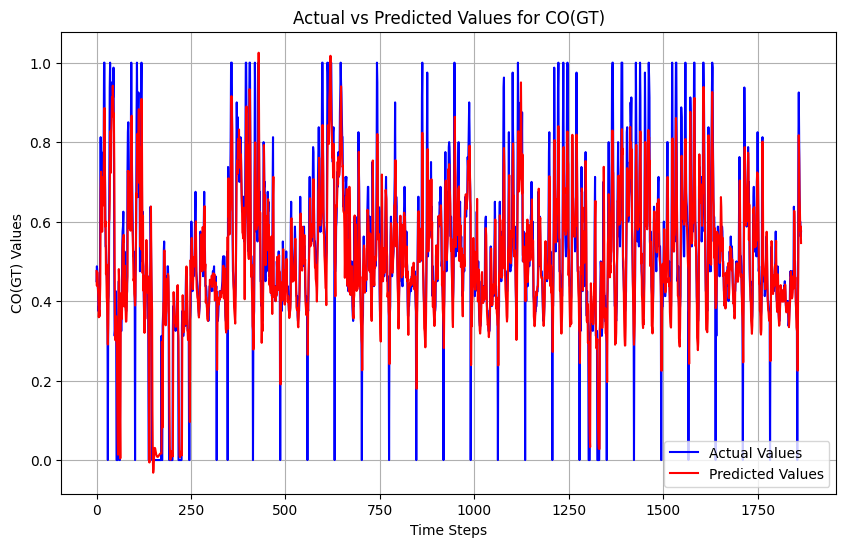

In [143]:
import matplotlib.pyplot as plt

# Plot Actual vs. Predicted for CO(GT)
plt.figure(figsize=(10, 6))
plt.plot(y_test_co_original, label="Actual Values", color="blue")
plt.plot(y_pred_co_original, label="Predicted Values", color="red")
plt.title("Actual vs Predicted Values for CO(GT)")
plt.xlabel("Time Steps")
plt.ylabel("CO(GT) Values")
plt.legend()
plt.grid()
plt.show()

# Plot Actual vs. Predicted for NO2(GT)

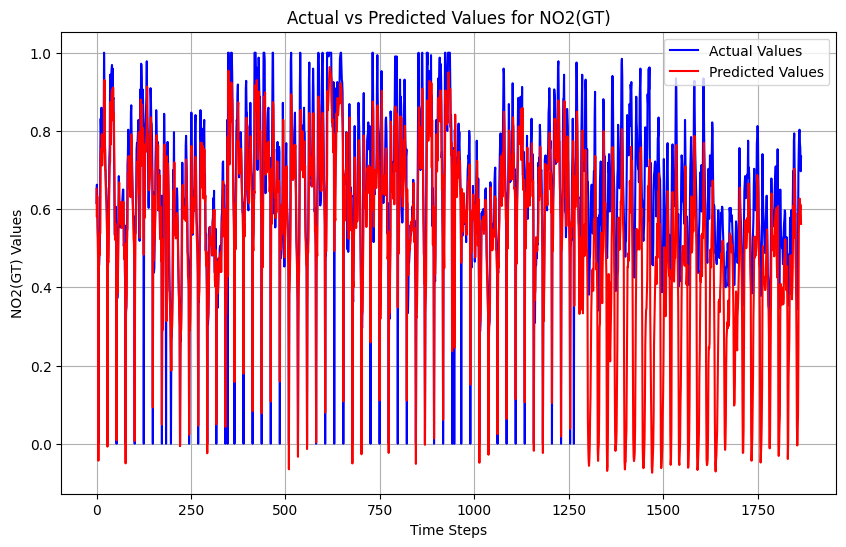

In [144]:
# Plot Actual vs. Predicted for NO2(GT)
plt.figure(figsize=(10, 6))
plt.plot(y_test_no2_original, label="Actual Values", color="blue")
plt.plot(y_pred_no2_original, label="Predicted Values", color="red")
plt.title("Actual vs Predicted Values for NO2(GT)")
plt.xlabel("Time Steps")
plt.ylabel("NO2(GT) Values")
plt.legend()
plt.grid()
plt.show()

# Both plot

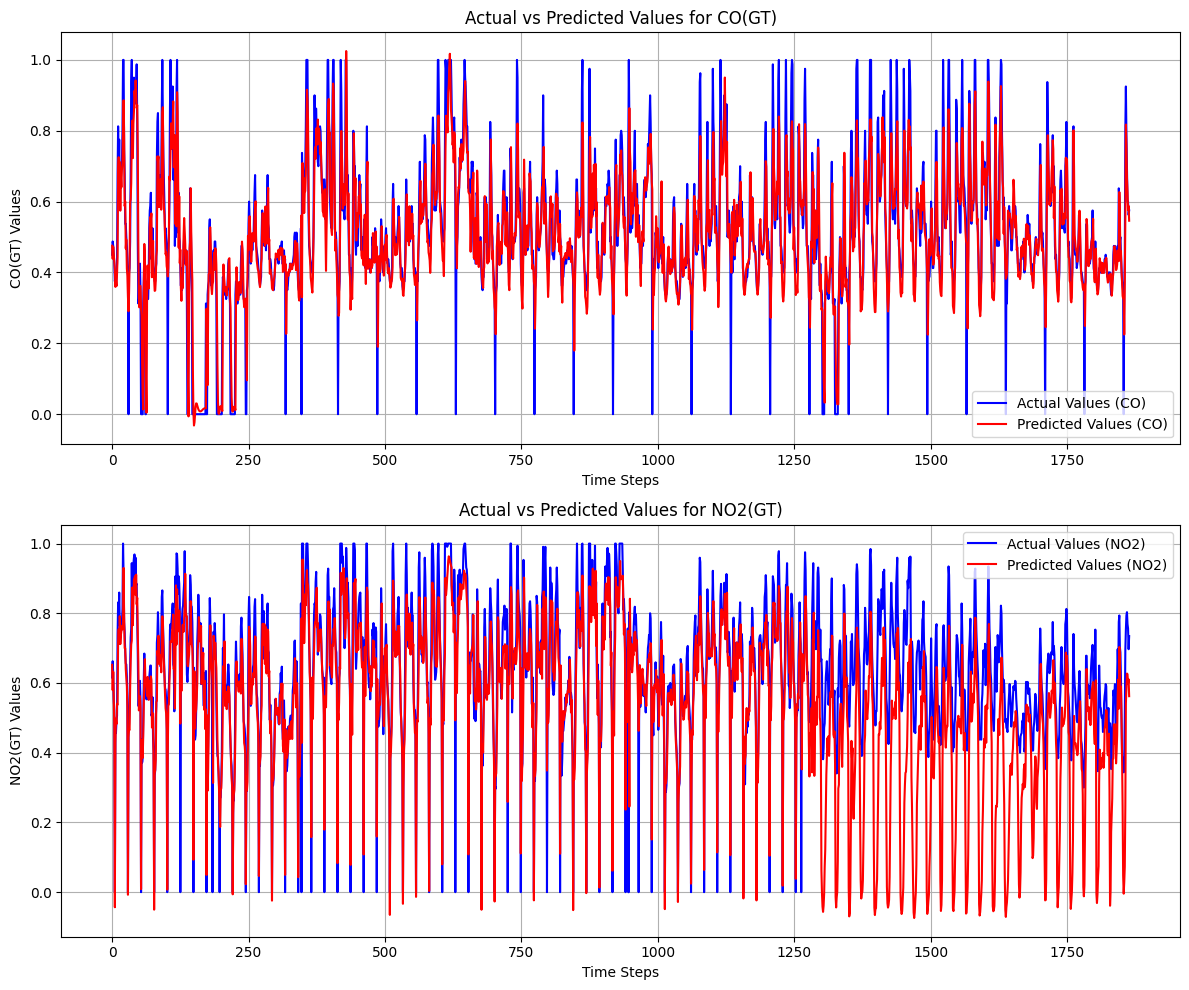

In [145]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plot for CO(GT)
axs[0].plot(y_test_co_original, label="Actual Values (CO)", color="blue")
axs[0].plot(y_pred_co_original, label="Predicted Values (CO)", color="red")
axs[0].set_title("Actual vs Predicted Values for CO(GT)")
axs[0].set_xlabel("Time Steps")
axs[0].set_ylabel("CO(GT) Values")
axs[0].legend()
axs[0].grid()

# Plot for NO2(GT)
axs[1].plot(y_test_no2_original, label="Actual Values (NO2)", color="blue")
axs[1].plot(y_pred_no2_original, label="Predicted Values (NO2)", color="red")
axs[1].set_title("Actual vs Predicted Values for NO2(GT)")
axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("NO2(GT) Values")
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">6. Visualization and Insights</h2>

  ---
- Generate forecasts for future dates and visualize the trends.
- Highlight seasonal patterns, peak times, and periods of concern.
- Provide actionable recommendations based on predicted trends.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


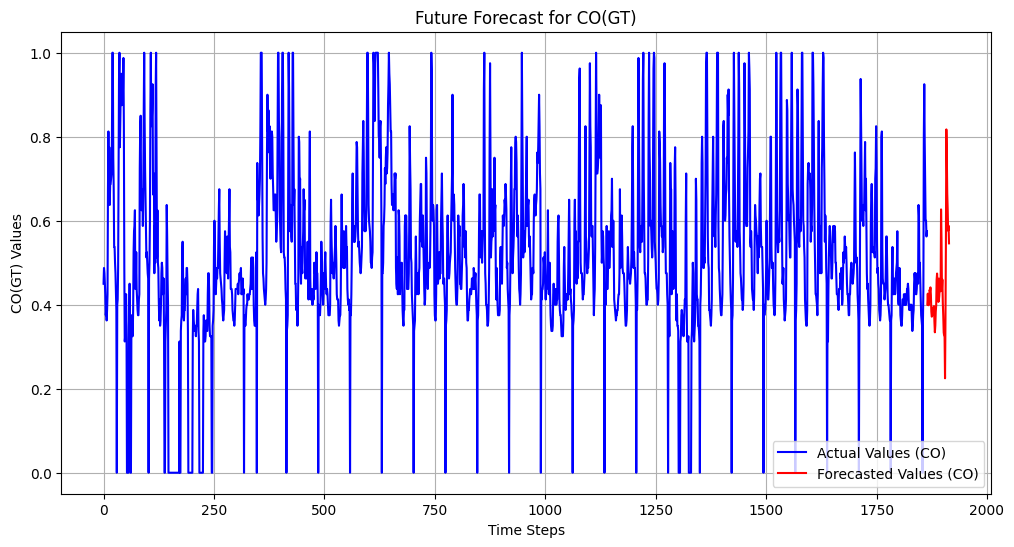

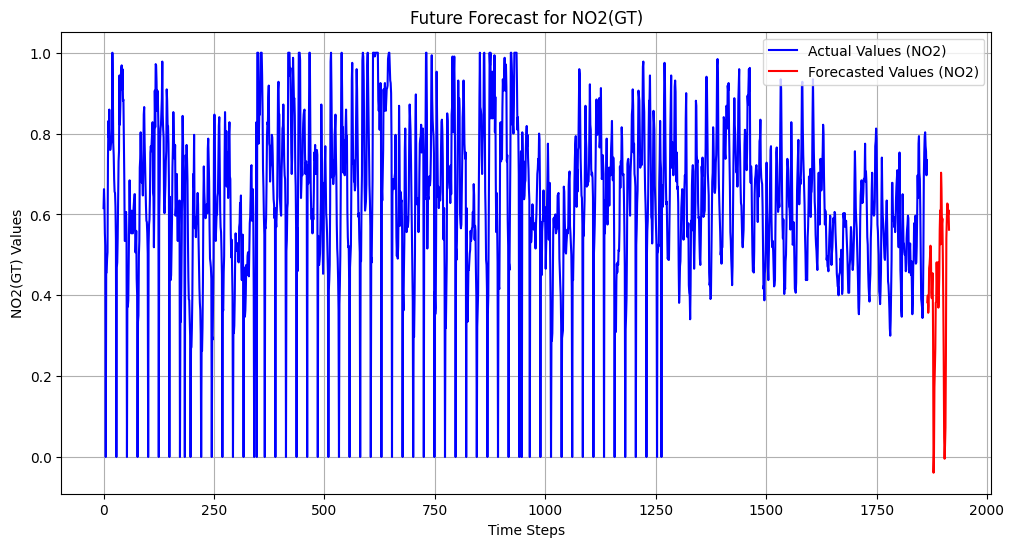

In [146]:
# Generate future forecasts
future_steps = 50  # Number of steps to forecast into the future
future_forecast_co = model_co.predict(X_test_co[-future_steps:])
future_forecast_no2 = model_no2.predict(X_test_no2[-future_steps:])

# Visualize forecasts
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_co_original)), y_test_co_original, label='Actual Values (CO)', color='blue')
plt.plot(range(len(y_test_co_original), len(y_test_co_original) + future_steps),
         future_forecast_co, label='Forecasted Values (CO)', color='red')
plt.title('Future Forecast for CO(GT)')
plt.xlabel('Time Steps')
plt.ylabel('CO(GT) Values')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_no2_original)), y_test_no2_original, label='Actual Values (NO2)', color='blue')
plt.plot(range(len(y_test_no2_original), len(y_test_no2_original) + future_steps),
         future_forecast_no2, label='Forecasted Values (NO2)', color='red')
plt.title('Future Forecast for NO2(GT)')
plt.xlabel('Time Steps')
plt.ylabel('NO2(GT) Values')
plt.legend()
plt.grid()
plt.show()

Available columns in the DataFrame:
Index(['CO(GT)', 'CO_lag1', 'CO_lag2'], dtype='object')


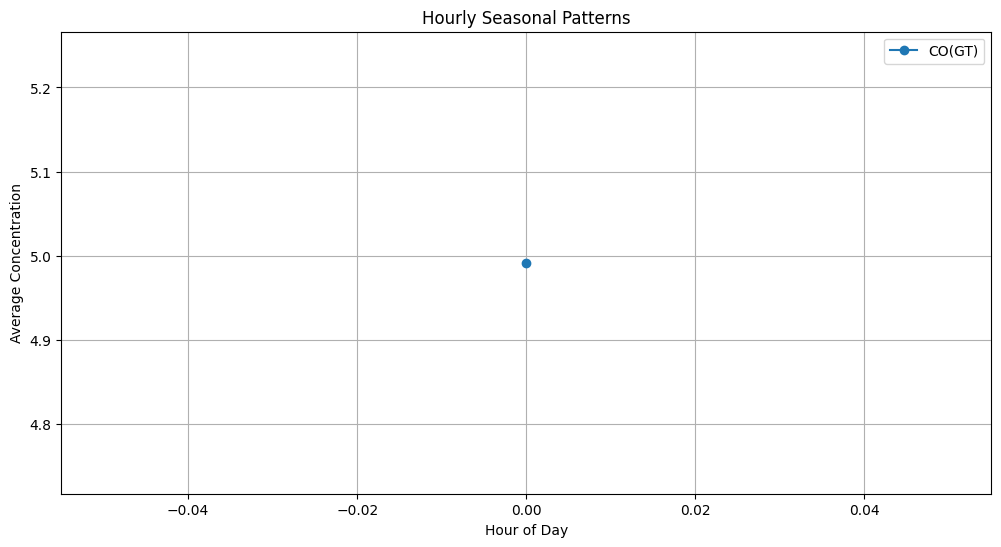

In [152]:
# Check available columns
print("Available columns in the DataFrame:")
print(df.columns)

# Dynamically include 'NO2(GT)' only if it exists
columns_to_analyze = ['CO(GT)']
if 'NO2(GT)' in df.columns:
    columns_to_analyze.append('NO2(GT)')

# Group by hour
hourly_avg = df.groupby(df.index.hour)[columns_to_analyze].mean()

# Plot hourly patterns
plt.figure(figsize=(12, 6))
for column in columns_to_analyze:
    plt.plot(hourly_avg.index, hourly_avg[column], label=column, marker='o')

plt.title('Hourly Seasonal Patterns')
plt.xlabel('Hour of Day')
plt.ylabel('Average Concentration')
plt.legend()
plt.grid()
plt.show()

Available columns in the DataFrame:
Index(['CO(GT)', 'CO_lag1', 'CO_lag2'], dtype='object')
Column 'NO2(GT)' not found. Please check the column name.


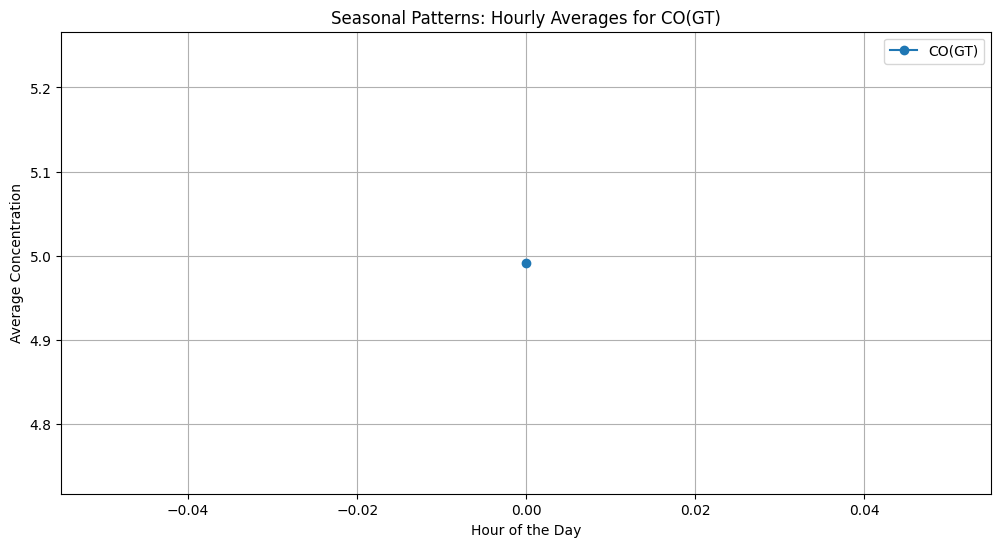

In [149]:
import matplotlib.pyplot as plt

# Check available column names
print("Available columns in the DataFrame:")
print(df.columns)

# Verify if 'NO2(GT)' exists in the DataFrame
if 'NO2(GT)' not in df.columns:
    print("Column 'NO2(GT)' not found. Please check the column name.")
    # Use 'CO(GT)' only if 'NO2(GT)' is missing
    hourly_avg = df.groupby(df.index.hour)[['CO(GT)']].mean()
    
    # Plot for 'CO(GT)' only
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_avg.index, hourly_avg['CO(GT)'], label='CO(GT)', marker='o')
    plt.title('Seasonal Patterns: Hourly Averages for CO(GT)')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Concentration')
    plt.legend()
    plt.grid()
    plt.show()
else:
    # Proceed if 'NO2(GT)' exists
    hourly_avg = df.groupby(df.index.hour)[['CO(GT)', 'NO2(GT)']].mean()

    # Plot for both 'CO(GT)' and 'NO2(GT)'
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_avg.index, hourly_avg['CO(GT)'], label='CO(GT)', marker='o', color='blue')
    plt.plot(hourly_avg.index, hourly_avg['NO2(GT)'], label='NO2(GT)', marker='o', color='green')
    plt.title('Seasonal Patterns: Hourly Averages')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Concentration')
    plt.legend()
    plt.grid()
    plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">7. Provide Actionable Recommendations Based on Predicted Trends</h2>

  ---

#### Steps:
- Based on forecasted trends and seasonal patterns, suggest actionable steps.
- Recommendations could include:
  - **Policy-level actions**: Stricter emissions control during peak times.
  - **Public advisories**: Alerts for high-pollution periods.
  - **Infrastructure planning**: Adjusting traffic or industry schedules.

---

#### Example Recommendations:

##### **For Policymakers:**
- Implement traffic restrictions during peak pollution hours to reduce **CO(GT)** levels.
- Strengthen industrial emissions regulations during winter months to control **NO2(GT)**.

##### **For the Public:**
- Avoid outdoor activities during peak pollution hours.
- Use masks or air purifiers in high-pollution periods.

##### **For City Planners:**
- Increase green spaces in high-pollution areas.
- Optimize traffic flow during peak times to reduce congestion.

## Author
**Md. Rasel Sarker**  
Email: [rasel.sarker6933@gmail.com](mailto:rasel.sarker6933@gmail.com)  


<h1 align="left">
 <h2><img src = "https://media2.giphy.com/media/QssGEmpkyEOhBCb7e1/giphy.gif?cid=ecf05e47a0n3gi1bfqntqmob8g9aid1oyj2wr3ds3mg700bl&rid=giphy.gif" width=30px valign="bottom"> 🌐 Connect with Me:</h2>
</h1>

<p align="center">
  <a href="mailto:rasel.sarker6933@gmail.com"><img src="https://img.shields.io/badge/Email-rasel.sarker6933@gmail.com-blue?style=flat-square&logo=gmail"></a>
  <a href="https://github.com/raselsarker69"><img src="https://img.shields.io/badge/GitHub-%40Raselsarker-lightgrey?style=flat-square&logo=github"></a>
  <a href="https://www.linkedin.com/in/rasel-sarker-405160227/"><img src="https://img.shields.io/badge/LinkedIn-Rasel%20Sarker-blue?style=flat-square&logo=linkedin"></a>
  <a href="https://www.facebook.com/mdrasel.sarker.7773631"><img src="https://img.shields.io/badge/Facebook-%40Raselsarker-blue?style=flat-square&logo=facebook"></a>
  <a href="https://www.kaggle.com/mdraselsarker"><img src="https://img.shields.io/badge/Kaggle-%40Raselsarker-blue?style=flat-square&logo=kaggle"></a>
  <a href="https://www.youtube.com/@raselsarker69"><img src="https://img.shields.io/badge/YouTube-Rasel%20Sarker-red?style=flat-square&logo=youtube"></a>
  <a href="https://www.facebook.com/groups/832585175685301"><img src="https://img.shields.io/badge/Facebook%20Group-Rasel%20Sarker%20Group-blue?style=flat-square&logo=facebook"></a>
  <br>
  <img src="https://img.shields.io/badge/Phone-%2B8801581528651-green?style=flat-square&logo=whatsapp">
</p>
 

---

<div align="center">

Thank you for visiting my repository. I hope these projects inspire and guide your learning journey!

---

Feel free to explore, learn, and build upon these projects. Happy coding!<br>

&copy; 2025 ML Finall Projects.

</div>

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">Please like, Comment and Upvote My Notebook</h2>